In [2]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from matplotlib.dates import MonthLocator, DateFormatter, YearLocator
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import gc
from sklearn.pipeline import Pipeline
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy.stats import kruskal
from pmdarima import auto_arima

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# load first dataset
df = pd.read_csv('/kaggle/input/energy-consumption-generation-prices-and-weather/weather_features.csv')
df


,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,Seville,287.760,287.150,288.150,1028,54,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178392,2018-12-31 20:00:00+01:00,Seville,285.760,285.150,286.150,1029,62,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178393,2018-12-31 21:00:00+01:00,Seville,285.150,285.150,285.150,1028,58,4,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178394,2018-12-31 22:00:00+01:00,Seville,284.150,284.150,284.150,1029,57,4,60,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [5]:
# drop irrelevant columns in first dataset
# List of columns to drop
columns_to_drop = ['weather_id', 'weather_icon']

# Drop the specified columns
df.drop(columns=columns_to_drop, inplace=True)

In [6]:
# load second dataset
df1 = pd.read_csv('/kaggle/input/energy-consumption-generation-prices-and-weather/energy_dataset.csv')
df1

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


In [7]:
# pick only relevant columns in second dataset

df1 = df1[['time', 'generation solar']]
df1

,time,generation solar
0,2015-01-01 00:00:00+01:00,49.0
1,2015-01-01 01:00:00+01:00,50.0
2,2015-01-01 02:00:00+01:00,50.0
3,2015-01-01 03:00:00+01:00,50.0
4,2015-01-01 04:00:00+01:00,42.0
...,...,...
35059,2018-12-31 19:00:00+01:00,85.0
35060,2018-12-31 20:00:00+01:00,33.0
35061,2018-12-31 21:00:00+01:00,31.0
35062,2018-12-31 22:00:00+01:00,31.0


In [8]:
# Perform the inner join based on different columns in both dataframes
df = pd.merge(df, df1, left_on='dt_iso', right_on='time', how='inner')
df

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_main,weather_description,time,generation solar
0,2015-01-01 00:00:00+01:00,Valencia,270.475000,270.475000,270.475000,1001,77,1,62,0.0,0.0,0.0,0,clear,sky is clear,2015-01-01 00:00:00+01:00,49.0
1,2015-01-01 00:00:00+01:00,Madrid,267.325000,267.325000,267.325000,971,63,1,309,0.0,0.0,0.0,0,clear,sky is clear,2015-01-01 00:00:00+01:00,49.0
2,2015-01-01 00:00:00+01:00,Bilbao,269.657312,269.657312,269.657312,1036,97,0,226,0.0,0.0,0.0,0,clear,sky is clear,2015-01-01 00:00:00+01:00,49.0
3,2015-01-01 00:00:00+01:00,Barcelona,281.625000,281.625000,281.625000,1035,100,7,58,0.0,0.0,0.0,0,clear,sky is clear,2015-01-01 00:00:00+01:00,49.0
4,2015-01-01 00:00:00+01:00,Seville,273.375000,273.375000,273.375000,1039,75,1,21,0.0,0.0,0.0,0,clear,sky is clear,2015-01-01 00:00:00+01:00,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 23:00:00+01:00,Valencia,279.140000,278.150000,280.150000,1029,75,2,300,0.0,0.0,0.0,0,clear,sky is clear,2018-12-31 23:00:00+01:00,31.0
178392,2018-12-31 23:00:00+01:00,Madrid,275.150000,275.150000,275.150000,1031,74,1,360,0.0,0.0,0.0,0,clear,sky is clear,2018-12-31 23:00:00+01:00,31.0
178393,2018-12-31 23:00:00+01:00,Bilbao,275.600000,275.150000,276.150000,1034,93,2,100,0.0,0.0,0.0,0,clear,sky is clear,2018-12-31 23:00:00+01:00,31.0
178394,2018-12-31 23:00:00+01:00,Barcelona,280.130000,277.150000,283.150000,1028,100,5,310,0.0,0.0,0.0,0,clear,sky is clear,2018-12-31 23:00:00+01:00,31.0


In [9]:
# drop the time column in resulting dataset
# List of columns to drop
column_to_drop = ['time']

# Drop the specified columns
df.drop(columns=column_to_drop, inplace=True)

In [10]:
df.columns

Index(['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h',
       'clouds_all', 'weather_main', 'weather_description',
       'generation solar'],
      dtype='object')

- dt_iso: The date and time of the data observation in ISO format  localized to CET, which indicates the timestamp of the recorded weather and solar generation data.

- city_name: The name of the city or location where the weather and solar energy data were recorded. This column helps to identify the specific geographical location.

- temp: The temperature in Kelvin at the time of the observation. Temperature is an important factor that can influence solar energy generation, as higher temperatures can impact the efficiency of solar panels.

- temp_min: The minimum temperature recorded within the hour leading up to the observation time.

- temp_max: The maximum temperature recorded within a certain time period (e.g., hour) leading up to the observation time.

pressure: The atmospheric pressure at the observation time measured in hectoPascal(hPa). Atmospheric pressure can indirectly affect solar energy generation through its influence on weather conditions.

- humidity: The relative humidity at the observation time measured in percentage. Humidity can impact solar energy generation as it affects cloud formation and overall weather conditions.

- wind_speed: The wind speed at the observation time measured in meters/secs. Wind can have an impact on solar energy generation, as strong winds can cool down solar panels and affect their efficiency.

- wind_deg: The wind direction at the observation time. Wind direction can provide information about the prevailing wind patterns, which may be relevant for certain solar panel installations.

- rain_1h: The amount of rainfall (measured in mm) recorded in the last hour leading up to the observation time. Rainfall can directly impact solar energy generation, as clouds and rain can reduce the amount of sunlight reaching the solar panels.

- rain_3h: The amount of rainfall (measured in mm) recorded in the last three hours leading up to the observation time.

- snow_3h: The amount of snowfall (measured in mm) recorded in the three hours leading up to the observation time.

- clouds_all: The percentage of cloud cover at the observation time. Cloud cover is a crucial factor affecting solar energy generation since clouds block sunlight.

- weather_main: A short description of the weather condition at the observation time. It might include values like 'clear', 'cloudy', 'rain', etc.

- weather_description: A more detailed description of the weather condition at the observation time. It might provide additional information about the weather conditions, such as 'scattered clouds', 'heavy rain', etc.

- generation solar: The solar energy generation (measured in MegaWatts) measured at the observation time. This column represents the main target variable or the outcome of interest in the dataset, and it indicates the amount of solar energy generated at a given time and location.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178396 entries, 0 to 178395
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_main         178396 non-null  object 
 14  weather_description  178396 non-null  object 
 15  generation solar 

In [12]:
# drop duplicates

df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178375 entries, 0 to 178395
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178375 non-null  object 
 1   city_name            178375 non-null  object 
 2   temp                 178375 non-null  float64
 3   temp_min             178375 non-null  float64
 4   temp_max             178375 non-null  float64
 5   pressure             178375 non-null  int64  
 6   humidity             178375 non-null  int64  
 7   wind_speed           178375 non-null  int64  
 8   wind_deg             178375 non-null  int64  
 9   rain_1h              178375 non-null  float64
 10  rain_3h              178375 non-null  float64
 11  snow_3h              178375 non-null  float64
 12  clouds_all           178375 non-null  int64  
 13  weather_main         178375 non-null  object 
 14  weather_description  178375 non-null  object 
 15  generation solar 

### Some rows in the outcome of interest (generation solar) are null so we'll be dropping all rows where the outcome is null

In [13]:
# Drop rows where 'generation solar' is null
df.dropna(subset=['generation solar'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178285 entries, 0 to 178395
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178285 non-null  object 
 1   city_name            178285 non-null  object 
 2   temp                 178285 non-null  float64
 3   temp_min             178285 non-null  float64
 4   temp_max             178285 non-null  float64
 5   pressure             178285 non-null  int64  
 6   humidity             178285 non-null  int64  
 7   wind_speed           178285 non-null  int64  
 8   wind_deg             178285 non-null  int64  
 9   rain_1h              178285 non-null  float64
 10  rain_3h              178285 non-null  float64
 11  snow_3h              178285 non-null  float64
 12  clouds_all           178285 non-null  int64  
 13  weather_main         178285 non-null  object 
 14  weather_description  178285 non-null  object 
 15  generation solar 

/tmp/ipykernel_32/2559521828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['generation solar'], inplace=True)


In [14]:
# Rename the date and generation solar column
df.rename(columns={'dt_iso': 'date_time'}, inplace=True)
df.rename(columns={'generation solar': 'solar_output'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178285 entries, 0 to 178395
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   date_time            178285 non-null  object 
 1   city_name            178285 non-null  object 
 2   temp                 178285 non-null  float64
 3   temp_min             178285 non-null  float64
 4   temp_max             178285 non-null  float64
 5   pressure             178285 non-null  int64  
 6   humidity             178285 non-null  int64  
 7   wind_speed           178285 non-null  int64  
 8   wind_deg             178285 non-null  int64  
 9   rain_1h              178285 non-null  float64
 10  rain_3h              178285 non-null  float64
 11  snow_3h              178285 non-null  float64
 12  clouds_all           178285 non-null  int64  
 13  weather_main         178285 non-null  object 
 14  weather_description  178285 non-null  object 
 15  solar_output     

/tmp/ipykernel_32/1077684871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'dt_iso': 'date_time'}, inplace=True)
/tmp/ipykernel_32/1077684871.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'generation solar': 'solar_output'}, inplace=True)


In [15]:
# Convert the combined column to datetime datatype
df['date_time']= pd.to_datetime(df['date_time'], format="%Y-%m-%d %H:%M:%S%z", utc=True)
df['date_time'].info()

<class 'pandas.core.series.Series'>
Int64Index: 178285 entries, 0 to 178395
Series name: date_time
Non-Null Count   Dtype              
--------------   -----              
178285 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1)
memory usage: 2.7 MB


/tmp/ipykernel_32/3108018503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_time']= pd.to_datetime(df['date_time'], format="%Y-%m-%d %H:%M:%S%z", utc=True)


In [16]:
# Check for duplicate dates
duplicate_dates = df.duplicated(subset='date_time', keep=False)
duplicate_dates

0         True
1         True
2         True
3         True
4         True
          ... 
178391    True
178392    True
178393    True
178394    True
178395    True
Length: 178285, dtype: bool

### There are duplicate dates so we'll need to handle it before going forward. 

### So first, we'll group the columns by the mean for the numerical columns and then take the first values of the categorical columns

In [17]:
df1 = df[['date_time', 'city_name', 'weather_main', 'weather_description']]

# drop the time column in resulting dataset
# List of columns to drop
column_to_drop = ['city_name', 'weather_main', 'weather_description']

# Drop the specified columns
df2 = df.drop(columns=column_to_drop)
df2

,date_time,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,solar_output
0,2014-12-31 23:00:00+00:00,270.475000,270.475000,270.475000,1001,77,1,62,0.0,0.0,0.0,0,49.0
1,2014-12-31 23:00:00+00:00,267.325000,267.325000,267.325000,971,63,1,309,0.0,0.0,0.0,0,49.0
2,2014-12-31 23:00:00+00:00,269.657312,269.657312,269.657312,1036,97,0,226,0.0,0.0,0.0,0,49.0
3,2014-12-31 23:00:00+00:00,281.625000,281.625000,281.625000,1035,100,7,58,0.0,0.0,0.0,0,49.0
4,2014-12-31 23:00:00+00:00,273.375000,273.375000,273.375000,1039,75,1,21,0.0,0.0,0.0,0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 22:00:00+00:00,279.140000,278.150000,280.150000,1029,75,2,300,0.0,0.0,0.0,0,31.0
178392,2018-12-31 22:00:00+00:00,275.150000,275.150000,275.150000,1031,74,1,360,0.0,0.0,0.0,0,31.0
178393,2018-12-31 22:00:00+00:00,275.600000,275.150000,276.150000,1034,93,2,100,0.0,0.0,0.0,0,31.0
178394,2018-12-31 22:00:00+00:00,280.130000,277.150000,283.150000,1028,100,5,310,0.0,0.0,0.0,0,31.0


In [18]:
# Check for duplicate dates
duplicate_dates = df2.duplicated(subset='date_time', keep=False)

if duplicate_dates.any():
    # Calculate the mean for all numeric columns
    df_mean = df2.groupby('date_time').mean().reset_index()
    df2 = df_mean
df2

,date_time,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,solar_output
0,2014-12-31 23:00:00+00:00,272.491463,272.491463,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,0.0,49.0
1,2015-01-01 00:00:00+00:00,272.512700,272.512700,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0.0,50.0
2,2015-01-01 01:00:00+00:00,272.099137,272.099137,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,0.0,50.0
3,2015-01-01 02:00:00+00:00,272.089469,272.089469,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,0.0,50.0
4,2015-01-01 03:00:00+00:00,272.145900,272.145900,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,0.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35041,2018-12-31 18:00:00+00:00,284.470000,283.350000,285.550000,1029.2,73.6,1.4,151.4,0.0,0.0,0.0,0.0,85.0
35042,2018-12-31 19:00:00+00:00,282.294000,280.950000,283.350000,1030.0,68.0,1.8,160.4,0.0,0.0,0.0,0.0,33.0
35043,2018-12-31 20:00:00+00:00,280.850000,280.350000,281.350000,1029.8,71.4,2.6,226.0,0.0,0.0,0.0,0.0,31.0
35044,2018-12-31 21:00:00+00:00,279.718000,278.750000,280.750000,1030.2,70.0,2.8,230.0,0.0,0.0,0.0,0.0,31.0


In [19]:
# List of columns to calculate the mode for
columns_to_mode = ['city_name', 'weather_main', 'weather_description']

# Check for duplicate dates
duplicate_dates = df1.duplicated(subset='date_time', keep=False)

if duplicate_dates.any():
    # Get the mode for the specified columns
    mode_values = df1.groupby('date_time')[columns_to_mode].agg(lambda x: x.value_counts().index[0])
    df1.drop(columns=columns_to_mode, inplace=True)
    df1 = df1.drop_duplicates(subset='date_time').merge(mode_values, on='date_time', how='inner')

/tmp/ipykernel_32/88053442.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(columns=columns_to_mode, inplace=True)


In [20]:
df1

,date_time,city_name,weather_main,weather_description
0,2014-12-31 23:00:00+00:00,Valencia,clear,sky is clear
1,2015-01-01 00:00:00+00:00,Valencia,clear,sky is clear
2,2015-01-01 01:00:00+00:00,Valencia,clear,sky is clear
3,2015-01-01 02:00:00+00:00,Valencia,clear,sky is clear
4,2015-01-01 03:00:00+00:00,Valencia,clear,sky is clear
...,...,...,...,...
35041,2018-12-31 18:00:00+00:00,Valencia,clear,sky is clear
35042,2018-12-31 19:00:00+00:00,Valencia,clear,sky is clear
35043,2018-12-31 20:00:00+00:00,Valencia,clear,sky is clear
35044,2018-12-31 21:00:00+00:00,Valencia,clear,sky is clear


In [21]:
# Inner merge based on 'ID'
df = pd.merge(df1, df2, on='date_time', how='inner')
df

,date_time,city_name,weather_main,weather_description,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,solar_output
0,2014-12-31 23:00:00+00:00,Valencia,clear,sky is clear,272.491463,272.491463,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,0.0,49.0
1,2015-01-01 00:00:00+00:00,Valencia,clear,sky is clear,272.512700,272.512700,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0.0,50.0
2,2015-01-01 01:00:00+00:00,Valencia,clear,sky is clear,272.099137,272.099137,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,0.0,50.0
3,2015-01-01 02:00:00+00:00,Valencia,clear,sky is clear,272.089469,272.089469,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,0.0,50.0
4,2015-01-01 03:00:00+00:00,Valencia,clear,sky is clear,272.145900,272.145900,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,0.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35041,2018-12-31 18:00:00+00:00,Valencia,clear,sky is clear,284.470000,283.350000,285.550000,1029.2,73.6,1.4,151.4,0.0,0.0,0.0,0.0,85.0
35042,2018-12-31 19:00:00+00:00,Valencia,clear,sky is clear,282.294000,280.950000,283.350000,1030.0,68.0,1.8,160.4,0.0,0.0,0.0,0.0,33.0
35043,2018-12-31 20:00:00+00:00,Valencia,clear,sky is clear,280.850000,280.350000,281.350000,1029.8,71.4,2.6,226.0,0.0,0.0,0.0,0.0,31.0
35044,2018-12-31 21:00:00+00:00,Valencia,clear,sky is clear,279.718000,278.750000,280.750000,1030.2,70.0,2.8,230.0,0.0,0.0,0.0,0.0,31.0


In [22]:
df = df.drop_duplicates()

In [23]:
# get the summary statistics

df.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,solar_output
count,35046.000000,35046.000000,35046.000000,35046.000000,35046.000000,35046.000000,35046.000000,35046.000000,35046.000000,35046.000000,35046.000000,35046.000000
mean,289.682451,288.398423,291.150278,1070.234745,68.213652,2.467845,166.608732,0.073200,0.000386,0.004849,24.735549,1432.665925
std,7.260897,7.122080,7.507286,2692.957486,14.892145,1.357914,57.503869,0.202594,0.003361,0.101129,17.305134,1680.119887
min,271.941863,270.550000,271.941863,812.400000,22.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,284.062000,282.950000,285.350000,1012.800000,56.800000,1.400000,126.400000,0.000000,0.000000,0.000000,12.000000,71.000000
50%,289.026000,287.750000,290.550000,1017.000000,69.800000,2.200000,166.000000,0.000000,0.000000,0.000000,22.400000,616.000000
75%,295.088000,293.616000,296.750000,1021.000000,80.200000,3.200000,207.800000,0.060000,0.000000,0.000000,35.000000,2578.000000
max,309.266000,308.550000,313.548000,202469.000000,100.000000,29.800000,338.000000,4.150000,0.463000,4.300000,93.600000,5792.000000


In [24]:
# Calculate the correlation matrix for numerical variables
correlation_matrix = df.corr()

# Sort the correlation matrix based on the correlation with 'solar_output' column in ascending order
correlation_with_solar = correlation_matrix['solar_output'].sort_values(ascending=True)

# Display the correlation matrix ordered by the correlation with 'solar_output' column
ordered_correlation_matrix = correlation_matrix[correlation_with_solar.index]
ordered_correlation_matrix

/tmp/ipykernel_32/262311444.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


,humidity,wind_deg,clouds_all,rain_1h,pressure,rain_3h,snow_3h,wind_speed,temp_min,temp_max,temp,solar_output
temp,-0.674649,-0.115212,-0.215096,-0.079572,-0.023209,-0.006767,-0.076960,0.100528,0.987922,0.985425,1.000000,0.423435
temp_min,-0.671671,-0.110639,-0.205042,-0.076941,-0.020718,0.006466,-0.069817,0.099855,1.000000,0.948895,0.987922,0.419877
temp_max,-0.656221,-0.122869,-0.222731,-0.082668,-0.025536,-0.021153,-0.083807,0.090359,0.948895,1.000000,0.985425,0.420623
pressure,-0.005305,0.033009,0.020070,0.048168,1.000000,-0.002401,-0.001260,0.015276,-0.020718,-0.025536,-0.023209,-0.006915
humidity,1.000000,0.020134,0.318940,0.104408,-0.005305,0.007999,-0.004007,-0.341124,-0.671671,-0.656221,-0.674649,-0.580597
wind_speed,-0.341124,0.361306,0.283874,0.182803,0.015276,-0.020191,0.060858,1.000000,0.099855,0.090359,0.100528,0.212021
wind_deg,0.020134,1.000000,0.118128,0.084911,0.033009,0.007059,0.045828,0.361306,-0.110639,-0.122869,-0.115212,-0.100933
rain_1h,0.104408,0.084911,0.327987,1.000000,0.048168,0.004980,0.076493,0.182803,-0.076941,-0.082668,-0.079572,-0.026761
rain_3h,0.007999,0.007059,0.027339,0.004980,-0.002401,1.000000,-0.002882,-0.020191,0.006466,-0.021153,-0.006767,0.004022
snow_3h,-0.004007,0.045828,0.054465,0.076493,-0.001260,-0.002882,1.000000,0.060858,-0.069817,-0.083807,-0.076960,0.023170


/tmp/ipykernel_32/2486482320.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


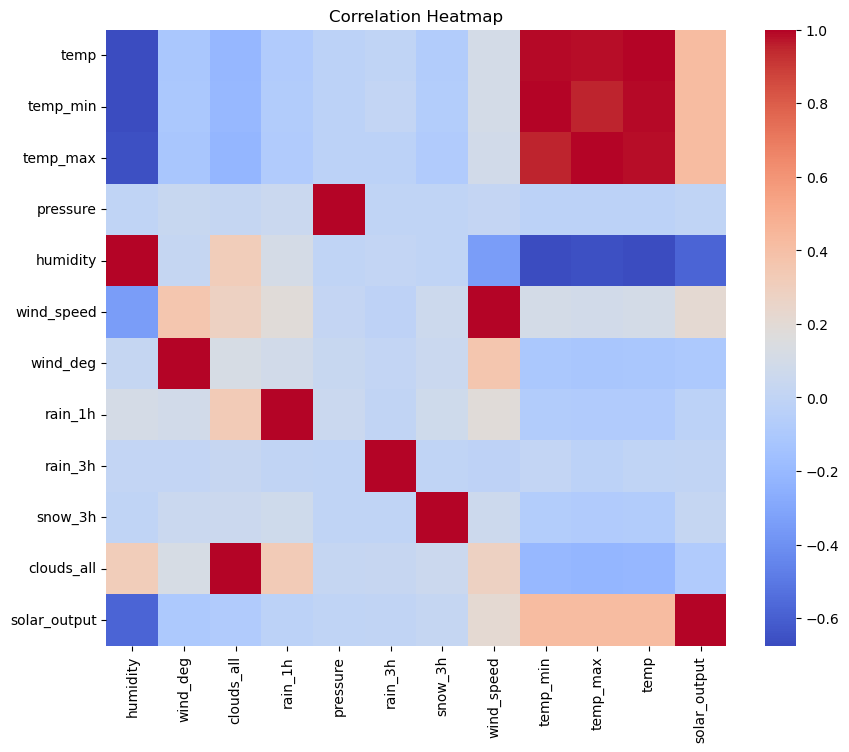

In [25]:
# Calculate the correlation matrix for numerical variables
correlation_matrix = df.corr()

# Sort the correlation matrix based on the correlation with 'Days_of_Inventory' column in ascending order
correlation_with_inventory_days = correlation_matrix['solar_output'].sort_values(ascending=True)

# Display the correlation matrix ordered by the correlation with 'Days_of_Inventory' column
ordered_correlation_matrix = correlation_matrix[correlation_with_inventory_days.index]

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(ordered_correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

According to the output above, below are the variables that are highly correlated or moderately correlated with the outcome: 'generated_power_kw':

- temp

- temp_max

- temp_min

- humidity

- wind_speed

- wind_deg
While building the models, we'll accommodate cases where the dataset includes all columns and when it includes only these correlated columns and categorical columns. Whichever case that has better performance based on the first model will be used all through the other models.

In [26]:
# print the unique values of the three categorical columns
print(df['city_name'].unique())
print()

print(df['weather_main'].unique())
print()

print(df['weather_description'].unique())

['Valencia' 'Seville' ' Barcelona' 'Madrid' 'Bilbao']

['clear' 'clouds' 'rain' 'fog' 'mist' 'thunderstorm' 'drizzle' 'haze'
 'snow']

['sky is clear' 'scattered clouds' 'broken clouds' 'few clouds'
 'overcast clouds' 'light rain' 'moderate rain' 'fog' 'mist'
 'heavy intensity rain' 'heavy intensity shower rain' 'very heavy rain'
 'thunderstorm with heavy rain' 'thunderstorm'
 'thunderstorm with light rain' 'thunderstorm with rain'
 'light intensity shower rain' 'light intensity drizzle' 'shower rain'
 'drizzle' 'proximity thunderstorm' 'proximity shower rain' 'haze'
 'heavy intensity drizzle' 'light snow']


In [27]:
# Perform label encoding on each of the three columns
label_mapping_city_name = {val: idx for idx, val in enumerate(df['city_name'].unique())}
label_mapping_weather_main = {val: idx for idx, val in enumerate(df['weather_main'].unique())}
label_mapping_weather_description = {val: idx for idx, val in enumerate(df['weather_description'].unique())}

df['city_name'] = df['city_name'].map(label_mapping_city_name)
df['weather_main'] = df['weather_main'].map(label_mapping_weather_main)
df['weather_description'] = df['weather_description'].map(label_mapping_weather_description)

df

,date_time,city_name,weather_main,weather_description,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,solar_output
0,2014-12-31 23:00:00+00:00,0,0,0,272.491463,272.491463,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,0.0,49.0
1,2015-01-01 00:00:00+00:00,0,0,0,272.512700,272.512700,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0.0,50.0
2,2015-01-01 01:00:00+00:00,0,0,0,272.099137,272.099137,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,0.0,50.0
3,2015-01-01 02:00:00+00:00,0,0,0,272.089469,272.089469,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,0.0,50.0
4,2015-01-01 03:00:00+00:00,0,0,0,272.145900,272.145900,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,0.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35041,2018-12-31 18:00:00+00:00,0,0,0,284.470000,283.350000,285.550000,1029.2,73.6,1.4,151.4,0.0,0.0,0.0,0.0,85.0
35042,2018-12-31 19:00:00+00:00,0,0,0,282.294000,280.950000,283.350000,1030.0,68.0,1.8,160.4,0.0,0.0,0.0,0.0,33.0
35043,2018-12-31 20:00:00+00:00,0,0,0,280.850000,280.350000,281.350000,1029.8,71.4,2.6,226.0,0.0,0.0,0.0,0.0,31.0
35044,2018-12-31 21:00:00+00:00,0,0,0,279.718000,278.750000,280.750000,1030.2,70.0,2.8,230.0,0.0,0.0,0.0,0.0,31.0


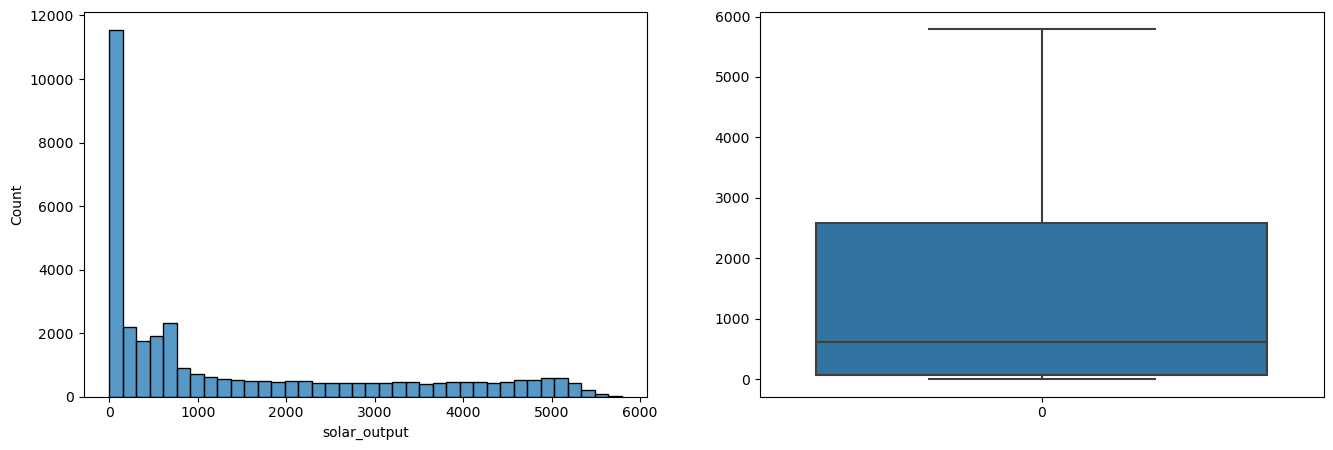

In [28]:
# check for outliers in target column
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(df['solar_output'])
plt.subplot(1,2,2)
sns.boxplot(df['solar_output'])
plt.show()

We could choose to handle the outliers. However, doing this will not make the model consider abnormalities in the meterological data variables especially since the climate change issues have made the weather to act funny sometimes. The graph above shows the distribution of the target column and there are no outliers so we'll be moving forward

In [29]:
# select the relevant columns
df = df[['date_time', 'city_name', 'temp', 'temp_min', 'temp_max', 'humidity', 'wind_speed', 'wind_deg', 'weather_main', 'weather_description', 'solar_output']]

/tmp/ipykernel_32/2995691188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['date_time'].dt.year


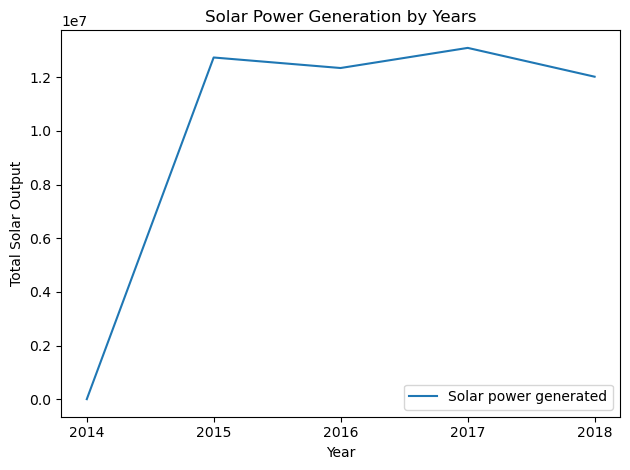

In [111]:
# Extract the year from 'date_time'
df['year'] = df['date_time'].dt.year

# Group by year and calculate the total solar output for each year
yearly_solar_output = df.groupby('year')['solar_output'].sum().reset_index()

# Create a new 'date' column using only the year for x-axis plotting
yearly_solar_output['date'] = pd.to_datetime(yearly_solar_output['year'], format='%Y')

# Visualize the power generated by years as a line chart
plt.plot(yearly_solar_output['date'], yearly_solar_output['solar_output'], label='Solar power generated')

# Set the major locator and formatter for the x-axis to show only the year
plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Total Solar Output')
plt.title('Solar Power Generation by Years')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

### According to the graph above, the power generated changes as time advances

### Let's see the months and years so we'll know how to split it

In [29]:
# Extract the month and year from 'date_time'
df['month'] = df['date_time'].dt.month
df['year'] = df['date_time'].dt.year

# Group by year and month, and calculate the total solar output for each month in each year
monthly_solar_output = df.groupby(['year', 'month'])['solar_output'].sum().reset_index()

# Create a pivot table to display the solar output for each month in each year
pivot_table = pd.pivot_table(monthly_solar_output, values='solar_output', index='month', columns='year', fill_value=0)

# Display the pivot table
pivot_table

/tmp/ipykernel_32/1307659289.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date_time'].dt.month
/tmp/ipykernel_32/1307659289.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['date_time'].dt.year


year,2014,2015,2016,2017,2018
month,,,,,
1,0,828577,763159,809786,782263
2,0,836335,875609,777819,837427
3,0,953698,1027516,1051457,1004755
4,0,1049430,1001102,1057546,1081193
5,0,1428551,1256751,1339227,1136012
6,0,1437039,1398839,1381723,1335736
7,0,1468494,1423413,1506706,1493684
8,0,1293794,1365874,1305085,1269957
9,0,1145713,1114709,1246657,1087666


### Since, we have four complete years, our train data will be based on 2015, 2016, and 2017. While the test data will be based on 2018

In [30]:
# check if the date has frequency
df.set_index('date_time', inplace=True)
df.index

DatetimeIndex(['2014-12-31 23:00:00+00:00', '2015-01-01 00:00:00+00:00',
               '2015-01-01 01:00:00+00:00', '2015-01-01 02:00:00+00:00',
               '2015-01-01 03:00:00+00:00', '2015-01-01 04:00:00+00:00',
               '2015-01-01 05:00:00+00:00', '2015-01-01 06:00:00+00:00',
               '2015-01-01 07:00:00+00:00', '2015-01-01 08:00:00+00:00',
               ...
               '2018-12-31 13:00:00+00:00', '2018-12-31 14:00:00+00:00',
               '2018-12-31 15:00:00+00:00', '2018-12-31 16:00:00+00:00',
               '2018-12-31 17:00:00+00:00', '2018-12-31 18:00:00+00:00',
               '2018-12-31 19:00:00+00:00', '2018-12-31 20:00:00+00:00',
               '2018-12-31 21:00:00+00:00', '2018-12-31 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date_time', length=35046, freq=None)

### The data doesn't have frequency so we'll fix the frequency for the data because they are hourly

In [31]:
df = df.asfreq("H")
df.index

DatetimeIndex(['2014-12-31 23:00:00+00:00', '2015-01-01 00:00:00+00:00',
               '2015-01-01 01:00:00+00:00', '2015-01-01 02:00:00+00:00',
               '2015-01-01 03:00:00+00:00', '2015-01-01 04:00:00+00:00',
               '2015-01-01 05:00:00+00:00', '2015-01-01 06:00:00+00:00',
               '2015-01-01 07:00:00+00:00', '2015-01-01 08:00:00+00:00',
               ...
               '2018-12-31 13:00:00+00:00', '2018-12-31 14:00:00+00:00',
               '2018-12-31 15:00:00+00:00', '2018-12-31 16:00:00+00:00',
               '2018-12-31 17:00:00+00:00', '2018-12-31 18:00:00+00:00',
               '2018-12-31 19:00:00+00:00', '2018-12-31 20:00:00+00:00',
               '2018-12-31 21:00:00+00:00', '2018-12-31 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date_time', length=35064, freq='H')

In [32]:
# Calculate the average of each column
column_means = df.mean()

# Fill the missing values with the corresponding column average
df = df.fillna(column_means)

# Now, check for infinite values (inf) in the DataFrame
inf_mask = df.isin([np.inf, -np.inf])
rows_with_inf = df[inf_mask.any(axis=1)]

# Check for missing values (NaN) in the DataFrame
nan_mask = df.isna()
rows_with_nan = df[nan_mask.any(axis=1)]

# Count the number of rows with inf or nan values
num_rows_with_inf = rows_with_inf.shape[0]
num_rows_with_nan = rows_with_nan.shape[0]

# Display counts
print("Number of rows with Infinite (inf) values:", num_rows_with_inf)
print("Number of rows with Missing (NaN) values:", num_rows_with_nan)

Number of rows with Infinite (inf) values: 0
Number of rows with Missing (NaN) values: 0


In [33]:
# Split the data into train and test sets
train_data = df.loc['2015':'2017']
test_data = df.loc['2018']

In [116]:
train_data

,city_name,temp,temp_min,temp_max,humidity,wind_speed,wind_deg,weather_main,weather_description,solar_output,year
date_time,,,,,,,,,,,
2015-01-01 00:00:00+00:00,0.0,272.512700,272.512700,272.512700,82.4,2.0,135.8,0.0,0.0,50.0,2015.0
2015-01-01 01:00:00+00:00,0.0,272.099137,272.099137,272.099137,82.0,2.4,119.0,0.0,0.0,50.0,2015.0
2015-01-01 02:00:00+00:00,0.0,272.089469,272.089469,272.089469,82.0,2.4,119.2,0.0,0.0,50.0,2015.0
2015-01-01 03:00:00+00:00,0.0,272.145900,272.145900,272.145900,82.0,2.4,118.4,0.0,0.0,42.0,2015.0
2015-01-01 04:00:00+00:00,0.0,272.024000,272.024000,272.024000,82.6,2.4,174.8,0.0,0.0,34.0,2015.0
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00+00:00,0.0,286.178000,284.750000,287.550000,65.6,5.4,246.0,1.0,1.0,9.0,2017.0
2017-12-31 20:00:00+00:00,0.0,285.946000,284.750000,287.150000,66.6,4.2,266.0,1.0,1.0,9.0,2017.0
2017-12-31 21:00:00+00:00,0.0,285.622000,284.550000,286.750000,68.2,4.0,226.0,1.0,1.0,9.0,2017.0


Notice how the train data begins at January 2015 and ends at December 2017

In [35]:
test_data

,city_name,temp,temp_min,temp_max,humidity,wind_speed,wind_deg,weather_main,weather_description,solar_output,year,month
date_time,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,0.0,283.628,282.75,284.75,60.0,3.2,236.6,0.0,0.0,9.0,2018.0,1.0
2018-01-01 01:00:00+00:00,0.0,283.170,281.75,284.55,68.0,3.6,160.0,0.0,0.0,9.0,2018.0,1.0
2018-01-01 02:00:00+00:00,0.0,282.432,280.95,283.95,76.2,3.6,168.0,0.0,0.0,9.0,2018.0,1.0
2018-01-01 03:00:00+00:00,0.0,281.988,280.75,283.35,71.0,4.2,212.0,0.0,0.0,9.0,2018.0,1.0
2018-01-01 04:00:00+00:00,0.0,281.710,281.15,282.35,63.6,3.6,184.0,0.0,0.0,9.0,2018.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,0.0,284.470,283.35,285.55,73.6,1.4,151.4,0.0,0.0,85.0,2018.0,12.0
2018-12-31 19:00:00+00:00,0.0,282.294,280.95,283.35,68.0,1.8,160.4,0.0,0.0,33.0,2018.0,12.0
2018-12-31 20:00:00+00:00,0.0,280.850,280.35,281.35,71.4,2.6,226.0,0.0,0.0,31.0,2018.0,12.0


Notice how the test data begins at January 2018 and ends at December 2018

# Modelling

# Support Vector Regression - This will be used instead of Support Vector Machines because all independent variables are continuous

### This is the case where all columns were included in the dataset

In [61]:
train_data = train_data.reset_index()
test_data = test_data.reset_index()
train_data

,date_time,city_name,temp,temp_min,temp_max,humidity,wind_speed,wind_deg,weather_main,weather_description,solar_output,year,month
0,2015-01-01 00:00:00+00:00,0.0,272.512700,272.512700,272.512700,82.4,2.0,135.8,0.0,0.0,50.0,2015.0,1.0
1,2015-01-01 01:00:00+00:00,0.0,272.099137,272.099137,272.099137,82.0,2.4,119.0,0.0,0.0,50.0,2015.0,1.0
2,2015-01-01 02:00:00+00:00,0.0,272.089469,272.089469,272.089469,82.0,2.4,119.2,0.0,0.0,50.0,2015.0,1.0
3,2015-01-01 03:00:00+00:00,0.0,272.145900,272.145900,272.145900,82.0,2.4,118.4,0.0,0.0,42.0,2015.0,1.0
4,2015-01-01 04:00:00+00:00,0.0,272.024000,272.024000,272.024000,82.6,2.4,174.8,0.0,0.0,34.0,2015.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2017-12-31 19:00:00+00:00,0.0,286.178000,284.750000,287.550000,65.6,5.4,246.0,1.0,1.0,9.0,2017.0,12.0
26300,2017-12-31 20:00:00+00:00,0.0,285.946000,284.750000,287.150000,66.6,4.2,266.0,1.0,1.0,9.0,2017.0,12.0
26301,2017-12-31 21:00:00+00:00,0.0,285.622000,284.550000,286.750000,68.2,4.0,226.0,1.0,1.0,9.0,2017.0,12.0
26302,2017-12-31 22:00:00+00:00,0.0,284.946000,283.550000,286.350000,69.0,3.2,282.0,1.0,0.0,9.0,2017.0,12.0


In [62]:
# get the independent variables to train the data into one place while doing same for the dependent variable
# Extract the target variable (y) and features (X)
y_train = train_data['solar_output'].values
y_test = test_data['solar_output'].values
X_train = train_data.drop(columns=['solar_output']).values
X_test = test_data.drop(columns=['solar_output']).values

### Extract date-time features and turn them to continuous variables to make them suitable for model training

In [65]:
# Function to extract date and time features
def extract_datetime_features(datetime_array):
    datetime_features = []
    for dt in datetime_array:
        month = dt.month
        day = dt.day
        hour = dt.hour
        minute = dt.minute
        datetime_features.append([month, day, hour, minute])
    return datetime_features

# Extract datetime features from X_train and X_test
X_train_datetime = X_train[:, 0]
X_test_datetime = X_test[:, 0]

# Extract date and time features from datetime objects
X_train_datetime_features = extract_datetime_features(X_train_datetime)
X_test_datetime_features = extract_datetime_features(X_test_datetime)

# Convert the extracted features back to numpy arrays
X_train_datetime_features = np.array(X_train_datetime_features)
X_test_datetime_features = np.array(X_test_datetime_features)

# Concatenate the date and time features with the rest of the data
X_train = np.concatenate([X_train_datetime_features, X_train[:, 1:]], axis=1)
X_test = np.concatenate([X_test_datetime_features, X_test[:, 1:]], axis=1)

In [66]:
# Standardize the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [67]:
# Create the SVR model
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Train the SVR model on the training data
svr.fit(X_train, y_train)

SVR()

### Evaluate the model

In [68]:
# Make predictions on the test data
y_pred = svr.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Calculate Adjusted R-squared
n = X_test.shape[0]  # Number of samples in test data
p = X_test.shape[1]  # Number of features in test data
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print the metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)
print("Adjusted R-squared:", adjusted_r2)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Squared Error (MSE): 2950675.945976164
Root Mean Squared Error (RMSE): 1717.753167942404
Mean Absolute Error (MAE): 1127.4864766785026
R-squared (R2): -0.07334609347949694
Adjusted R-squared: -0.07518758855008967
Mean Absolute Percentage Error (MAPE): 745.2399076789965


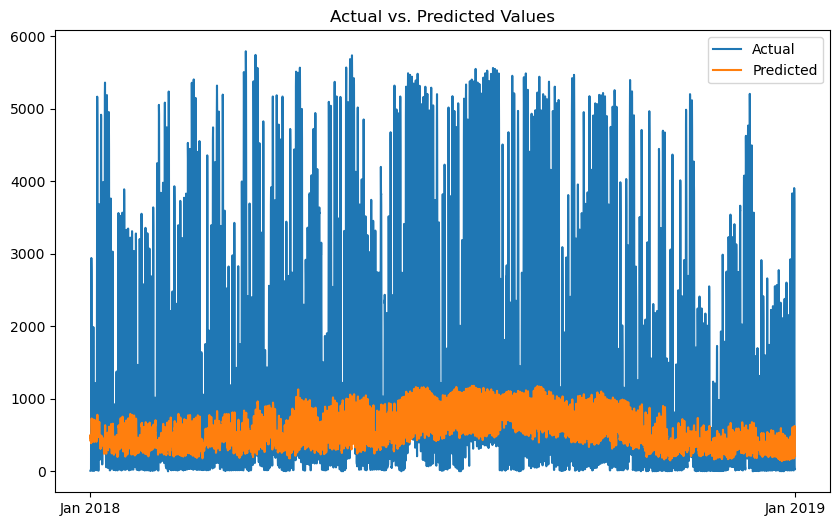

In [69]:
date_column = test_data['date_time']
plt.figure(figsize=(10, 6))
plt.plot(date_column, y_test, label='Actual')
plt.plot(date_column, y_pred, label='Predicted')
# Set the major locator and formatter for the x-axis
plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.legend()
plt.title('Actual vs. Predicted Values')
plt.show()

### Hyper parameter Tuning

In [ ]:
# Define hyperparameter grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Create SVR instance
svr = SVR()

# Create GridSearchCV instance with the SVR model and hyperparameter grid
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')

# Build a pipeline with the GridSearchCV
pipeline = Pipeline([
    ('grid_search', grid_search)
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = pipeline.named_steps['grid_search'].best_params_
print("Best Hyperparameters:", best_params)

# Get the best SVR model from the grid search
best_svr = pipeline.named_steps['grid_search'].best_estimator_

In [ ]:
# Make predictions on the test data
y_pred = svr.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Calculate Adjusted R-squared
n = X_test.shape[0]  # Number of samples in test data
p = X_test.shape[1]  # Number of features in test data
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print the metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)
print("Adjusted R-squared:", adjusted_r2)
print("Mean Absolute Percentage Error (MAPE):", mape)

In [ ]:
date_column = test_data['date_time']
plt.figure(figsize=(10, 6))
plt.plot(date_column, y_test, label='Actual')
plt.plot(date_column, y_pred, label='Predicted')
# Set the major locator and formatter for the x-axis
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.legend()
plt.title('Actual vs. Predicted Values')
plt.show()

## Now, we'll handle the one of fewer and correlated columns

In [96]:
df = df.reset_index()
# select the relevant columns
df = df[['date_time', 'city_name', 'temp', 'temp_min', 'temp_max', 'humidity', 'wind_speed', 'weather_main', 'weather_description', 'solar_output']]

In [97]:
# Extract the year from 'date_time'
df['year'] = df['date_time'].dt.year

# Split the data into train and test sets
train_data = df[df['year'].isin([2014, 2015, 2016, 2017])]
test_data = df[df['year'] == 2018]

# Remove the 'year' column as it is no longer needed
train_data.drop(columns='year', inplace=True)
test_data.drop(columns='year', inplace=True)

/tmp/ipykernel_32/522904345.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(columns='year', inplace=True)
/tmp/ipykernel_32/522904345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(columns='year', inplace=True)


In [85]:
train_data

,date_time,city_name,temp,temp_min,temp_max,humidity,wind_speed,weather_main,weather_description,solar_output
0,2014-12-31 23:00:00+00:00,0.0,272.491463,272.491463,272.491463,82.4,2.0,0.0,0.0,49.0
1,2015-01-01 00:00:00+00:00,0.0,272.512700,272.512700,272.512700,82.4,2.0,0.0,0.0,50.0
2,2015-01-01 01:00:00+00:00,0.0,272.099137,272.099137,272.099137,82.0,2.4,0.0,0.0,50.0
3,2015-01-01 02:00:00+00:00,0.0,272.089469,272.089469,272.089469,82.0,2.4,0.0,0.0,50.0
4,2015-01-01 03:00:00+00:00,0.0,272.145900,272.145900,272.145900,82.0,2.4,0.0,0.0,42.0
...,...,...,...,...,...,...,...,...,...,...
26300,2017-12-31 19:00:00+00:00,0.0,286.178000,284.750000,287.550000,65.6,5.4,1.0,1.0,9.0
26301,2017-12-31 20:00:00+00:00,0.0,285.946000,284.750000,287.150000,66.6,4.2,1.0,1.0,9.0
26302,2017-12-31 21:00:00+00:00,0.0,285.622000,284.550000,286.750000,68.2,4.0,1.0,1.0,9.0
26303,2017-12-31 22:00:00+00:00,0.0,284.946000,283.550000,286.350000,69.0,3.2,1.0,0.0,9.0


Notice how the train data begins at December 2014 and ends at December 2017

In [86]:
test_data

,date_time,city_name,temp,temp_min,temp_max,humidity,wind_speed,weather_main,weather_description,solar_output
26305,2018-01-01 00:00:00+00:00,0.0,283.628,282.75,284.75,60.0,3.2,0.0,0.0,9.0
26306,2018-01-01 01:00:00+00:00,0.0,283.170,281.75,284.55,68.0,3.6,0.0,0.0,9.0
26307,2018-01-01 02:00:00+00:00,0.0,282.432,280.95,283.95,76.2,3.6,0.0,0.0,9.0
26308,2018-01-01 03:00:00+00:00,0.0,281.988,280.75,283.35,71.0,4.2,0.0,0.0,9.0
26309,2018-01-01 04:00:00+00:00,0.0,281.710,281.15,282.35,63.6,3.6,0.0,0.0,9.0
...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,0.0,284.470,283.35,285.55,73.6,1.4,0.0,0.0,85.0
35060,2018-12-31 19:00:00+00:00,0.0,282.294,280.95,283.35,68.0,1.8,0.0,0.0,33.0
35061,2018-12-31 20:00:00+00:00,0.0,280.850,280.35,281.35,71.4,2.6,0.0,0.0,31.0
35062,2018-12-31 21:00:00+00:00,0.0,279.718,278.75,280.75,70.0,2.8,0.0,0.0,31.0


Notice how the test data begins at January 2018 and ends at December 2018

In [87]:
# get the independent variables to train the data into one place while doing same for the dependent variable
# Extract the target variable (y) and features (X)
y_train = train_data['solar_output'].values
y_test = test_data['solar_output'].values
X_train = train_data.drop(columns=['solar_output']).values
X_test = test_data.drop(columns=['solar_output']).values

### Extract date-time features and turn them to continuous variables to make them suitable for model training

In [88]:
# Function to extract date and time features
def extract_datetime_features(datetime_array):
    datetime_features = []
    for dt in datetime_array:
        month = dt.month
        day = dt.day
        hour = dt.hour
        minute = dt.minute
        datetime_features.append([month, day, hour, minute])
    return datetime_features

# Extract datetime features from X_train and X_test
X_train_datetime = X_train[:, 0]
X_test_datetime = X_test[:, 0]

# Extract date and time features from datetime objects
X_train_datetime_features = extract_datetime_features(X_train_datetime)
X_test_datetime_features = extract_datetime_features(X_test_datetime)

# Convert the extracted features back to numpy arrays
X_train_datetime_features = np.array(X_train_datetime_features)
X_test_datetime_features = np.array(X_test_datetime_features)

# Concatenate the date and time features with the rest of the data
X_train = np.concatenate([X_train_datetime_features, X_train[:, 1:]], axis=1)
X_test = np.concatenate([X_test_datetime_features, X_test[:, 1:]], axis=1)

In [89]:
# Standardize the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [56]:
# Create the SVR model
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Train the SVR model on the training data
svr.fit(X_train, y_train)

SVR()

### Evaluate the model

In [57]:
# Make predictions on the test data
y_pred = svr.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Calculate Adjusted R-squared
n = X_test.shape[0]  # Number of samples in test data
p = X_test.shape[1]  # Number of features in test data
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print the metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)
print("Adjusted R-squared:", adjusted_r2)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Squared Error (MSE): 2312891.7713393704
Root Mean Squared Error (RMSE): 1520.8194407421843
Mean Absolute Error (MAE): 1022.7926829602201
R-squared (R2): 0.1586560527619384
Adjusted R-squared: 0.1575016819219136
Mean Absolute Percentage Error (MAPE): 684.1185887273052


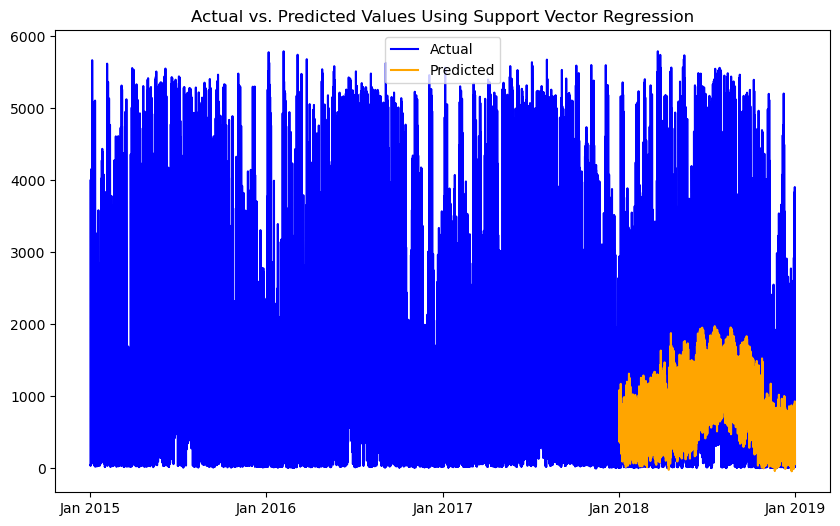

In [58]:
# Concatenate the train and test data
all_data = pd.concat([train_data, test_data], ignore_index=True)

# Create a new DataFrame to hold the predicted values with the corresponding date
predicted_data = pd.DataFrame({'date_time': test_data['date_time'], 'solar_output': y_pred})

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(all_data['date_time'], all_data['solar_output'], label='Actual', color='blue')
plt.plot(predicted_data['date_time'], predicted_data['solar_output'], label='Predicted', color='orange')

# Set the major locator and formatter for the x-axis
plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))

plt.legend()
plt.title('Actual vs. Predicted Values Using Support Vector Regression')
plt.show()

### Hyper parameter Tuning

In [ ]:
# Define hyperparameter grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Create SVR instance
svr = SVR()

# Create GridSearchCV instance with the SVR model and hyperparameter grid
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')

# Build a pipeline with the GridSearchCV
pipeline = Pipeline([
    ('grid_search', grid_search)
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = pipeline.named_steps['grid_search'].best_params_
print("Best Hyperparameters:", best_params)

# Get the best SVR model from the grid search
best_svr = pipeline.named_steps['grid_search'].best_estimator_

In [ ]:
# Make predictions on the test data
y_pred = svr.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Calculate Adjusted R-squared
n = X_test.shape[0]  # Number of samples in test data
p = X_test.shape[1]  # Number of features in test data
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print the metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)
print("Adjusted R-squared:", adjusted_r2)
print("Mean Absolute Percentage Error (MAPE):", mape)

In [ ]:
date_column = test_data['date_time']
plt.figure(figsize=(10, 6))
plt.plot(date_column, y_test, label='Actual')
plt.plot(date_column, y_pred, label='Predicted')
# Set the major locator and formatter for the x-axis
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.legend()
plt.title('Actual vs. Predicted Values')
plt.show()

# Random Forest

In [76]:
# Prepare lagged features

def create_lagged_features(df, lag_order):
    for i in range(1, lag_order + 1):
        df[f'lag_{i}'] = df['solar_output'].shift(i)
    df.dropna(inplace=True)

lag_order = 1
create_lagged_features(train_data, lag_order)
create_lagged_features(test_data, lag_order)
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

/tmp/ipykernel_32/3214934450.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{i}'] = df['solar_output'].shift(i)
/tmp/ipykernel_32/3214934450.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
/tmp/ipykernel_32/3214934450.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.dropna(inplace=True)
/tmp/ipykernel_32/3214934450.py:12: S

In [77]:
# get the independent variables to train the data into one place while doing same for the dependent variable
# Extract the target variable (y) and features (X)
y_train = train_data['solar_output'].values
y_test = test_data['solar_output'].values
X_train = train_data.drop(columns=['solar_output']).values
X_test = test_data.drop(columns=['solar_output']).values

### Extract date-time features and turn them to continuous variables to make them suitable for model training

In [78]:
# Function to extract date and time features
def extract_datetime_features(datetime_array):
    datetime_features = []
    for dt in datetime_array:
        month = dt.month
        day = dt.day
        hour = dt.hour
        minute = dt.minute
        datetime_features.append([month, day, hour, minute])
    return datetime_features

# Extract datetime features from X_train and X_test
X_train_datetime = X_train[:, 0]
X_test_datetime = X_test[:, 0]

# Extract date and time features from datetime objects
X_train_datetime_features = extract_datetime_features(X_train_datetime)
X_test_datetime_features = extract_datetime_features(X_test_datetime)

# Convert the extracted features back to numpy arrays
X_train_datetime_features = np.array(X_train_datetime_features)
X_test_datetime_features = np.array(X_test_datetime_features)

# Concatenate the date and time features with the rest of the data
X_train = np.concatenate([X_train_datetime_features, X_train[:, 1:]], axis=1)
X_test = np.concatenate([X_test_datetime_features, X_test[:, 1:]], axis=1)

In [79]:
# Standardize the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [80]:
# Initialize the Random Forest Regressor with desired hyperparameters
random_forest = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Train the model on the training data
random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [81]:
# Make predictions on the test set
y_pred_before_tuning = random_forest.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred_before_tuning)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_before_tuning)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred_before_tuning)

# Calculate Adjusted R-squared
n = X_test.shape[0]  # Number of samples in test data
p = X_test.shape[1]  # Number of features in test data
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred_before_tuning) / y_test)) * 100

# Print the metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)
print("Adjusted R-squared:", adjusted_r2)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Squared Error (MSE): 20331.904256633778
Root Mean Squared Error (RMSE): 142.58998652301563
Mean Absolute Error (MAE): 87.25408720129982
R-squared (R2): 0.9926051012711269
Adjusted R-squared: 0.992592408345056
Mean Absolute Percentage Error (MAPE): 85.75802416783445


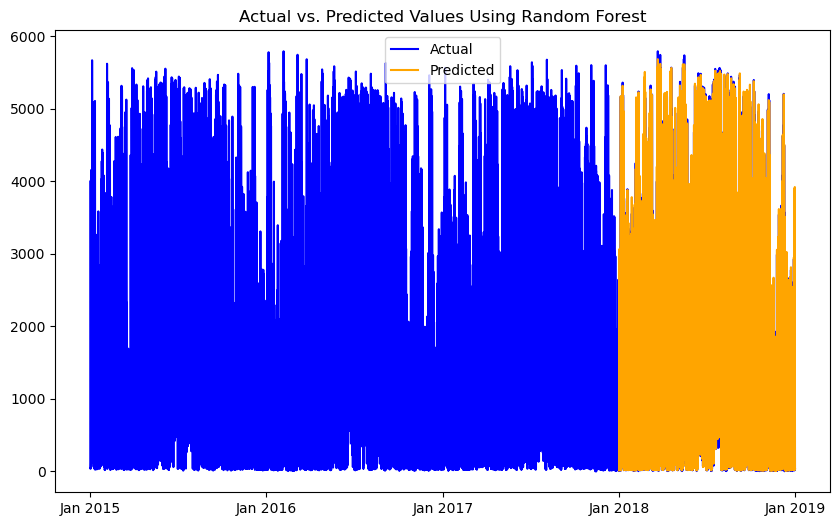

In [82]:
# Concatenate the train and test data
all_data = pd.concat([train_data, test_data], ignore_index=True)

# Create a new DataFrame to hold the predicted values with the corresponding date
predicted_data = pd.DataFrame({'date_time': test_data['date_time'], 'solar_output': y_pred_before_tuning})

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(all_data['date_time'], all_data['solar_output'], label='Actual', color='blue')
plt.plot(predicted_data['date_time'], predicted_data['solar_output'], label='Predicted', color='orange')

# Set the major locator and formatter for the x-axis
plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))

plt.legend()
plt.title('Actual vs. Predicted Values Using Random Forest')
plt.show()

## Hyper Parameter Tuning

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],    # Number of trees in the forest
    'max_depth': [None, 10, 20],       # Maximum depth of the trees
    'min_samples_split': [2, 5, 10]    # Minimum number of samples required to split an internal node
}

# Perform grid search with cross-validation (5-fold cross-validation in this example)
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_after_tuning = best_rf_model.predict(X_test)

# Evaluate the model's performance after tuning
mse_after_tuning = mean_squared_error(y_test, y_pred_after_tuning)
mae_after_tuning = mean_absolute_error(y_test, y_pred_after_tuning)
rmse_after_tuning = np.sqrt(mse_after_tuning)
mape_after_tuning = np.mean(np.abs((y_test - y_pred_after_tuning) / y_test)) * 100

r2_after_tuning = r2_score(y_test, y_pred_after_tuning)

# Calculate the adjusted R-squared
num_features = X_train.shape[1]
n = len(y_test)
adjusted_r2_after_tuning = 1 - (1 - r2_after_tuning) * (n - 1) / (n - num_features - 1)

# Print evaluation metrics after tuning
print("Mean Squared Error (MSE) after tuning:", mse_after_tuning)
print("Mean Absolute Error (MAE) after tuning:", mae_after_tuning)
print("Root Mean Squared Error (RMSE) after tuning:", rmse_after_tuning)
print("R-squared after tuning:", r2_after_tuning)
print("Adjusted R-squared after tuning:", adjusted_r2_after_tuning)
print("Mean Absolute Percentage Error (MAPE) after tuning:", mape_after_tuning)

In [ ]:
date_column = test_data['date_time']

# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot the actual values in the first subplot (ax1)
ax1.plot(date_column, y_test, label='Actual')
ax1.set_ylabel('Actual Values')
ax1.legend()

# Plot the predicted values in the second subplot (ax2)
ax2.plot(date_column, y_pred_after_tuning, label='Predicted', color='orange')
ax2.set_ylabel('Predicted Values')
ax2.legend()

# Set the major locator and formatter for the x-axis (common for both subplots)
ax1.xaxis.set_major_locator(YearLocator())
ax1.xaxis.set_major_formatter(DateFormatter('%b %Y'))
ax2.xaxis.set_major_locator(YearLocator())
ax2.xaxis.set_major_formatter(DateFormatter('%b %Y'))

# Add a title to the entire figure
plt.suptitle('Actual vs. Predicted Values')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## Linear Regression

In [90]:
from sklearn.linear_model import LinearRegression

# Initialize the Linear Regression model
linear_regression = LinearRegression()

# Train the model on the training data
linear_regression.fit(X_train, y_train)

LinearRegression()

In [91]:
# Make predictions on the test set
y_pred_before_tuning = linear_regression.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred_before_tuning)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_before_tuning)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred_before_tuning)

# Calculate Adjusted R-squared
n = X_test.shape[0]  # Number of samples in test data
p = X_test.shape[1]  # Number of features in test data
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred_before_tuning) / y_test)) * 100

# Print the metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)
print("Adjusted R-squared:", adjusted_r2)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Squared Error (MSE): 1696170.3646420133
Root Mean Squared Error (RMSE): 1302.371054900259
Mean Absolute Error (MAE): 1020.7041486523159
R-squared (R2): 0.3829963479226106
Adjusted R-squared: 0.38214978448504733
Mean Absolute Percentage Error (MAPE): 1366.5446009056093


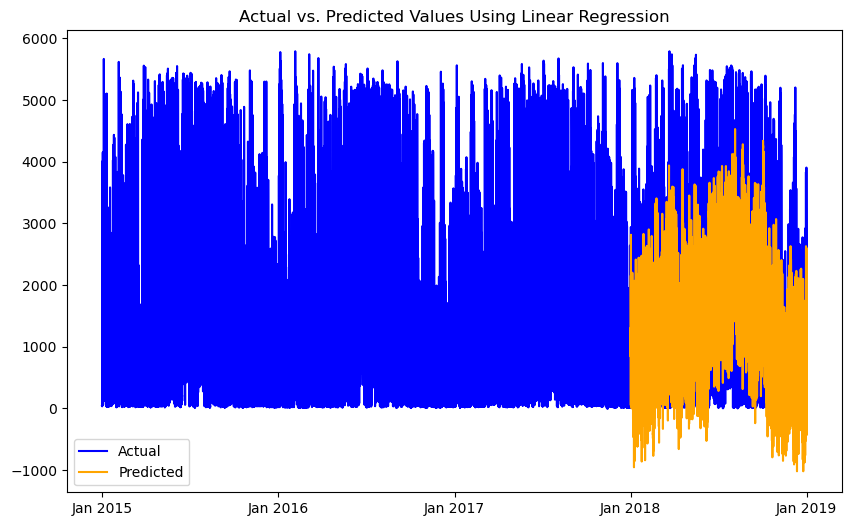

In [92]:
# Concatenate the train and test data
all_data = pd.concat([train_data, test_data], ignore_index=True)

# Create a new DataFrame to hold the predicted values with the corresponding date
predicted_data = pd.DataFrame({'date_time': test_data['date_time'], 'solar_output': y_pred_before_tuning})

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(all_data['date_time'], all_data['solar_output'], label='Actual', color='blue')
plt.plot(predicted_data['date_time'], predicted_data['solar_output'], label='Predicted', color='orange')

# Set the major locator and formatter for the x-axis
plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))

plt.legend()
plt.title('Actual vs. Predicted Values Using Linear Regression')
plt.show()

# ARIMA (SARIMA instead. You'll find out why)

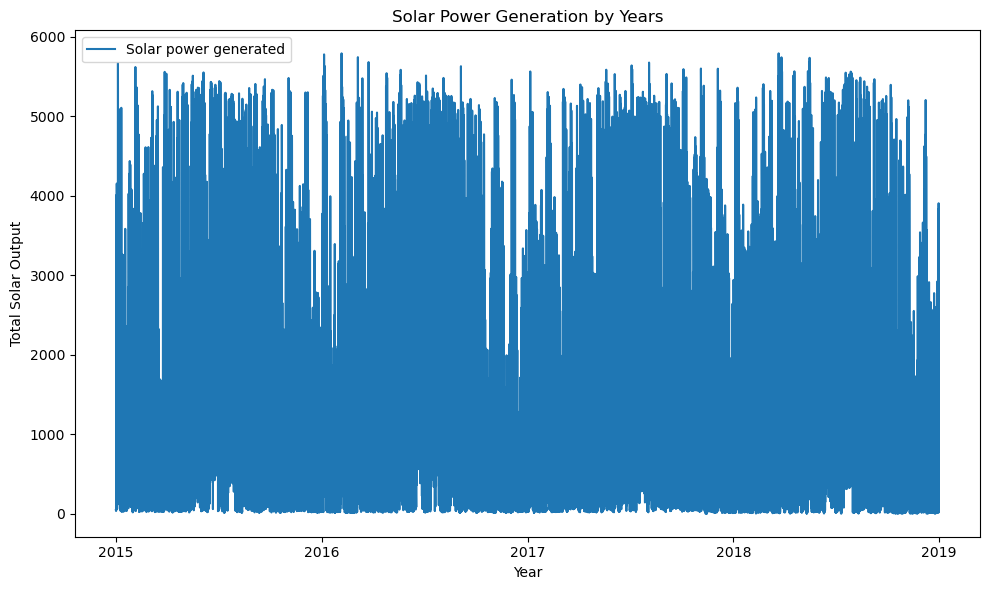

In [142]:
# Visualize the power generated by years as a line chart
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['solar_output'], label='Solar power generated')

# Set the major locator and formatter for the x-axis to show only the year
plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Total Solar Output')
plt.title('Solar Power Generation by Years')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


#### There's some form of pattern in the latter few years but we'll still check if the data is stationary

In [34]:
# check for stationarity
test_result=adfuller(df['solar_output'])

In [35]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(solar_output):
    result=adfuller(solar_output)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [36]:
adfuller_test(df['solar_output'])

ADF Test Statistic : -13.91167754804707
p-value : 5.495946655778885e-26
#Lags Used : 52
Number of Observations Used : 35011
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


### It has been confirmed. The data is stationary so there's won't be need for differencing to make it stationary

<Figure size 1000x600 with 0 Axes>

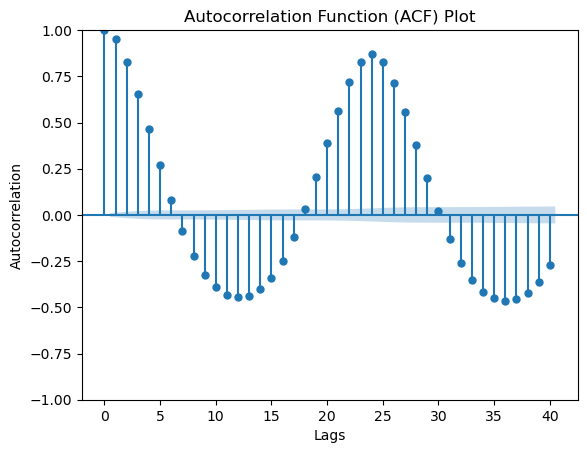

<Figure size 1000x600 with 0 Axes>

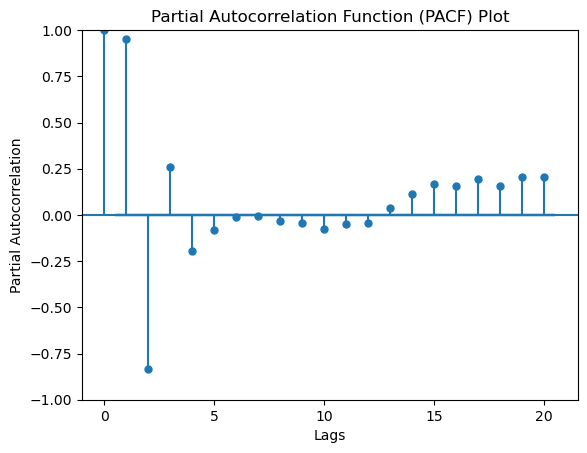

In [37]:
# Create the ACF plot
plt.figure(figsize=(10, 6))
plot_acf(df['solar_output'], lags=40, alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()

# Create the PACF plot
plt.figure(figsize=(10, 6))
plot_pacf(df['solar_output'], lags=20, alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.show()


In [378]:
def seasonality_test(series):
    seasonal = False
    years_with_data = len(series) // 12
    idx = np.arange(len(series)) % 12
    if years_with_data > 0:
        start_month = 12 - years_with_data + 1
        idx += start_month
    H_statistic, p_value = kruskal(series, idx)
    if p_value <= 0.05:
        seasonal = True
    return seasonal, p_value

# The data is from 2014 to 2018 with December data in 2014

# Call the seasonality_test function
has_seasonality, p_value = seasonality_test(df['solar_output'])

print("P-value:", p_value)
if has_seasonality:
    print("The data exhibits seasonality.")
else:
    print("The data does not exhibit seasonality.")


P-value: 0.0
The data exhibits seasonality.


## The data is seasonal so we'll be using SARIMA. And not ARIMA.

In [98]:
train_data = df.loc['2015-01-01':'2017-12-31']
test_data = df.loc['2018-01-01':'2018-12-31']

In [117]:
train_data

,city_name,temp,temp_min,temp_max,humidity,wind_speed,wind_deg,weather_main,weather_description,solar_output,year
date_time,,,,,,,,,,,
2015-01-01 00:00:00+00:00,0.0,272.512700,272.512700,272.512700,82.4,2.0,135.8,0.0,0.0,50.0,2015.0
2015-01-01 01:00:00+00:00,0.0,272.099137,272.099137,272.099137,82.0,2.4,119.0,0.0,0.0,50.0,2015.0
2015-01-01 02:00:00+00:00,0.0,272.089469,272.089469,272.089469,82.0,2.4,119.2,0.0,0.0,50.0,2015.0
2015-01-01 03:00:00+00:00,0.0,272.145900,272.145900,272.145900,82.0,2.4,118.4,0.0,0.0,42.0,2015.0
2015-01-01 04:00:00+00:00,0.0,272.024000,272.024000,272.024000,82.6,2.4,174.8,0.0,0.0,34.0,2015.0
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00+00:00,0.0,286.178000,284.750000,287.550000,65.6,5.4,246.0,1.0,1.0,9.0,2017.0
2017-12-31 20:00:00+00:00,0.0,285.946000,284.750000,287.150000,66.6,4.2,266.0,1.0,1.0,9.0,2017.0
2017-12-31 21:00:00+00:00,0.0,285.622000,284.550000,286.750000,68.2,4.0,226.0,1.0,1.0,9.0,2017.0


In [118]:
# 'date_time' is the datetime index of your train_data and test_data
train_frequency = pd.infer_freq(train_data.index)
test_frequency = pd.infer_freq(test_data.index)

print("Frequency of train_data:", train_frequency)
print("Frequency of test_data:", test_frequency)

if train_frequency == test_frequency:
    print("The frequencies of train_data and test_data match.")
else:
    print("The frequencies of train_data and test_data do not match.")

Frequency of train_data: H
Frequency of test_data: H
The frequencies of train_data and test_data match.


The train_data and test_data exhibit hourly frequencies

In the SARIMA model, the p,d, and q values to be used are 1, 1, and 5 while the P, D, and Q values to be used are 1, 0 and 5

In [121]:
# Drop the dependent variable column from exog_train
exog_train = train_data.drop(columns=['solar_output', 'year'])
# Drop the dependent variable column from exog_test
exog_test = test_data.drop(columns=['solar_output', 'year'])

model_sarimax = sm.tsa.statespace.SARIMAX(train_data.solar_output, exogenous=exog_train, order=(1, 1, 5), seasonal_order=(1, 0, 5, 12))
model_sarimax_fit = model_sarimax.fit()
print(model_sarimax_fit.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['exogenous']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35210D+00    |proj g|=  1.04505D+00


 This problem is unconstrained.



At iterate    5    f=  6.95190D+00    |proj g|=  1.06295D-02

At iterate   10    f=  6.94523D+00    |proj g|=  5.90435D-02

At iterate   15    f=  6.90812D+00    |proj g|=  3.06085D-02

At iterate   20    f=  6.87454D+00    |proj g|=  3.99047D-02

At iterate   25    f=  6.86830D+00    |proj g|=  8.22677D-03

At iterate   30    f=  6.86544D+00    |proj g|=  1.27109D-02

At iterate   35    f=  6.86411D+00    |proj g|=  8.84568D-03

At iterate   40    f=  6.84394D+00    |proj g|=  7.69521D-02

At iterate   45    f=  6.81950D+00    |proj g|=  4.09990D-02

At iterate   50    f=  6.81778D+00    |proj g|=  3.87219D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                       solar_output   No. Observations:                26304
Model:             SARIMAX(1, 1, 5)x(1, 0, 5, 12)   Log Likelihood             -179334.897
Date:                            Sun, 30 Jul 2023   AIC                         358695.794
Time:                                    09:21:35   BIC                         358802.100
Sample:                                01-01-2015   HQIC                        358730.118
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7974      0.005    152.534      0.000       0.787       0.808
ma.L1         -0.1504      0.005   

## SARIMA Model Evaluation

In [122]:
# Make predictions using the fitted SARIMAX model
start_date = test_data.index[0]  # Get the first date of the test_data index
end_date = test_data.index[-1]   # Get the last date of the test_data index

predictions = model_sarimax_fit.predict(start=start_date, end=end_date, dynamic=False)
predictions[:10]

2018-01-01 00:00:00+00:00     -28.065446
2018-01-01 01:00:00+00:00     -54.034269
2018-01-01 02:00:00+00:00     -28.677692
2018-01-01 03:00:00+00:00      75.759718
2018-01-01 04:00:00+00:00     246.851747
2018-01-01 05:00:00+00:00     456.928712
2018-01-01 06:00:00+00:00     705.868920
2018-01-01 07:00:00+00:00    1045.292142
2018-01-01 08:00:00+00:00    1516.296001
2018-01-01 09:00:00+00:00    1994.916426
Freq: H, Name: predicted_mean, dtype: float64

In [123]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_data.solar_output, predictions)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data.solar_output, predictions)

# Calculate R-squared
r2 = r2_score(test_data.solar_output, predictions)
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate the number of features in the model (if applicable)
num_features = X_train.shape[1] if 'X_train' in locals() else None

# Calculate Adjusted R-squared (if num_features is provided)
adjusted_r2 = 1 - (1 - r2) * (len(test_data) - 1) / (len(test_data) - num_features - 1) if num_features is not None else None

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test_data.solar_output - predictions) / test_data.solar_output)) * 100

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)
print("Adjusted R-squared:", adjusted_r2)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Squared Error (MSE): 1104069.7984026845
Root Mean Squared Error (RMSE): 1050.7472571473525
Mean Absolute Error (MAE): 826.8939850516462
R-squared: 0.5983804976414748
Adjusted R-squared: 0.5978294532751014
Mean Absolute Percentage Error (MAPE): 1077.9852235314445


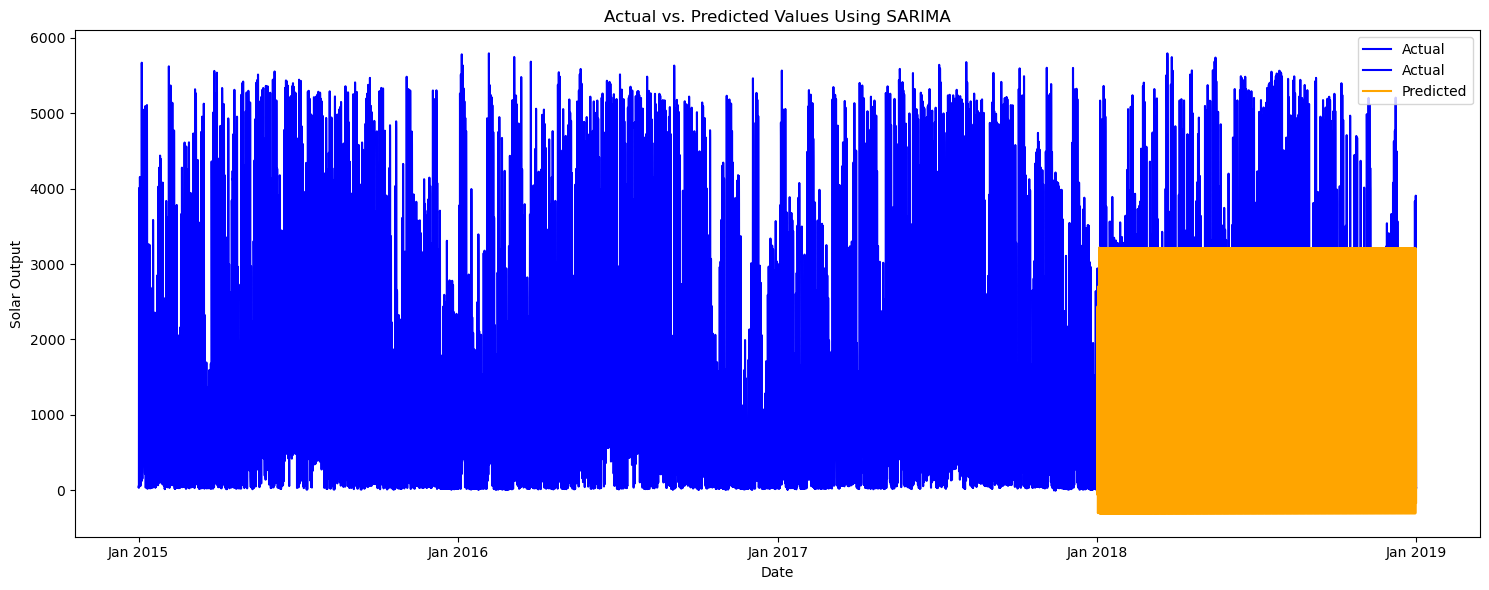

In [124]:
# Get the date_column from the index of the train_data and test_data
train_date_column = train_data.index
test_date_column = test_data.index

# Plot the data
plt.figure(figsize=(15, 6))

# Plot the actual values of the train data
plt.plot(train_date_column, train_data.solar_output, label='Actual', color='blue')

# Plot the actual values of the test data
plt.plot(test_date_column, test_data.solar_output, label='Actual', color='blue')

# Plot the predicted values
plt.plot(test_date_column, predictions, label='Predicted', color='orange')

# Set the major locator and formatter for the x-axis
years_locator = YearLocator()
years_formatter = DateFormatter('%b %Y')
plt.gca().xaxis.set_major_locator(years_locator)
plt.gca().xaxis.set_major_formatter(years_formatter)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Solar Output')
plt.title('Actual vs. Predicted Values Using SARIMA')
plt.legend()


# Display the plot
plt.tight_layout()
plt.show()

In [125]:
test_data

,city_name,temp,temp_min,temp_max,humidity,wind_speed,wind_deg,weather_main,weather_description,solar_output,year
date_time,,,,,,,,,,,
2018-01-01 00:00:00+00:00,0.0,283.628,282.75,284.75,60.0,3.2,236.6,0.0,0.0,9.0,2018.0
2018-01-01 01:00:00+00:00,0.0,283.170,281.75,284.55,68.0,3.6,160.0,0.0,0.0,9.0,2018.0
2018-01-01 02:00:00+00:00,0.0,282.432,280.95,283.95,76.2,3.6,168.0,0.0,0.0,9.0,2018.0
2018-01-01 03:00:00+00:00,0.0,281.988,280.75,283.35,71.0,4.2,212.0,0.0,0.0,9.0,2018.0
2018-01-01 04:00:00+00:00,0.0,281.710,281.15,282.35,63.6,3.6,184.0,0.0,0.0,9.0,2018.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,0.0,284.470,283.35,285.55,73.6,1.4,151.4,0.0,0.0,85.0,2018.0
2018-12-31 19:00:00+00:00,0.0,282.294,280.95,283.35,68.0,1.8,160.4,0.0,0.0,33.0,2018.0
2018-12-31 20:00:00+00:00,0.0,280.850,280.35,281.35,71.4,2.6,226.0,0.0,0.0,31.0,2018.0


In [83]:
# Concatenate the train and test data
all_data = pd.concat([train_data, test_data], ignore_index=True)
all_data

,city_name,temp,temp_min,temp_max,humidity,wind_speed,wind_deg,weather_main,weather_description,solar_output,year,month
0,0.0,272.512700,272.512700,272.512700,82.4,2.0,135.8,0.0,0.0,50.0,2015.0,1.0
1,0.0,272.099137,272.099137,272.099137,82.0,2.4,119.0,0.0,0.0,50.0,2015.0,1.0
2,0.0,272.089469,272.089469,272.089469,82.0,2.4,119.2,0.0,0.0,50.0,2015.0,1.0
3,0.0,272.145900,272.145900,272.145900,82.0,2.4,118.4,0.0,0.0,42.0,2015.0,1.0
4,0.0,272.024000,272.024000,272.024000,82.6,2.4,174.8,0.0,0.0,34.0,2015.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35058,0.0,284.470000,283.350000,285.550000,73.6,1.4,151.4,0.0,0.0,85.0,2018.0,12.0
35059,0.0,282.294000,280.950000,283.350000,68.0,1.8,160.4,0.0,0.0,33.0,2018.0,12.0
35060,0.0,280.850000,280.350000,281.350000,71.4,2.6,226.0,0.0,0.0,31.0,2018.0,12.0
35061,0.0,279.718000,278.750000,280.750000,70.0,2.8,230.0,0.0,0.0,31.0,2018.0,12.0


# Exponential Smoothing

In [126]:
df

,city_name,temp,temp_min,temp_max,humidity,wind_speed,wind_deg,weather_main,weather_description,solar_output,year
date_time,,,,,,,,,,,
2014-12-31 23:00:00+00:00,0.0,272.491463,272.491463,272.491463,82.4,2.0,135.2,0.0,0.0,49.0,2014.0
2015-01-01 00:00:00+00:00,0.0,272.512700,272.512700,272.512700,82.4,2.0,135.8,0.0,0.0,50.0,2015.0
2015-01-01 01:00:00+00:00,0.0,272.099137,272.099137,272.099137,82.0,2.4,119.0,0.0,0.0,50.0,2015.0
2015-01-01 02:00:00+00:00,0.0,272.089469,272.089469,272.089469,82.0,2.4,119.2,0.0,0.0,50.0,2015.0
2015-01-01 03:00:00+00:00,0.0,272.145900,272.145900,272.145900,82.0,2.4,118.4,0.0,0.0,42.0,2015.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,0.0,284.470000,283.350000,285.550000,73.6,1.4,151.4,0.0,0.0,85.0,2018.0
2018-12-31 19:00:00+00:00,0.0,282.294000,280.950000,283.350000,68.0,1.8,160.4,0.0,0.0,33.0,2018.0
2018-12-31 20:00:00+00:00,0.0,280.850000,280.350000,281.350000,71.4,2.6,226.0,0.0,0.0,31.0,2018.0


In [127]:
train_data = df.loc['2015-01-01':'2017-12-31']
test_data = df.loc['2018-01-01':'2018-12-31']
train_data

,city_name,temp,temp_min,temp_max,humidity,wind_speed,wind_deg,weather_main,weather_description,solar_output,year
date_time,,,,,,,,,,,
2015-01-01 00:00:00+00:00,0.0,272.512700,272.512700,272.512700,82.4,2.0,135.8,0.0,0.0,50.0,2015.0
2015-01-01 01:00:00+00:00,0.0,272.099137,272.099137,272.099137,82.0,2.4,119.0,0.0,0.0,50.0,2015.0
2015-01-01 02:00:00+00:00,0.0,272.089469,272.089469,272.089469,82.0,2.4,119.2,0.0,0.0,50.0,2015.0
2015-01-01 03:00:00+00:00,0.0,272.145900,272.145900,272.145900,82.0,2.4,118.4,0.0,0.0,42.0,2015.0
2015-01-01 04:00:00+00:00,0.0,272.024000,272.024000,272.024000,82.6,2.4,174.8,0.0,0.0,34.0,2015.0
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00+00:00,0.0,286.178000,284.750000,287.550000,65.6,5.4,246.0,1.0,1.0,9.0,2017.0
2017-12-31 20:00:00+00:00,0.0,285.946000,284.750000,287.150000,66.6,4.2,266.0,1.0,1.0,9.0,2017.0
2017-12-31 21:00:00+00:00,0.0,285.622000,284.550000,286.750000,68.2,4.0,226.0,1.0,1.0,9.0,2017.0


In [128]:
# fill zero values in the solar_output column with the median grouped by month and year

# Extract the month and year from the 'date_time' column and create new columns
train_data['Year'] = train_data.index.year
train_data['Month'] = train_data.index.month

# Calculate the median of the 'solar_output' column grouped by 'Year' and 'Month'
column_name = 'solar_output'
median_by_month_year = train_data[train_data[column_name] > 0].groupby(['Year', 'Month'])[column_name].median()

# Function to fill zero values based on the median of the corresponding month and year
def fill_zero_with_median(row):
    year = row['Year']
    month = row['Month']
    if row[column_name] == 0:
        return median_by_month_year[year, month]
    else:
        return row[column_name]

# Apply the fill_zero_with_median function to fill the zero values in the 'solar_output' column
train_data[column_name] = train_data.apply(fill_zero_with_median, axis=1)

# Drop the temporary 'Year' and 'Month' columns
train_data.drop(['Year', 'Month'], axis=1, inplace=True)

/tmp/ipykernel_32/140801912.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Year'] = train_data.index.year
/tmp/ipykernel_32/140801912.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Month'] = train_data.index.month
/tmp/ipykernel_32/140801912.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Grid search for the best model parameters
best_mse = np.inf
best_model = None
best_seasonal = None
best_seasonal_periods = None

seasonal_types = ['add', 'mul']  # Additive, Additive with Damped Trend, and Multiplicative
seasonal_periods_values = [7, 30]  # Possible seasonal periods to try

for seasonal_type in seasonal_types:
    for seasonal_periods in seasonal_periods_values:
        model = ExponentialSmoothing(train_data.solar_output, seasonal=seasonal_type, seasonal_periods=seasonal_periods).fit()
        forecast = model.predict(start=test_data.index[0], end=test_data.index[-1])
        mse = mean_squared_error(test_data.solar_output, predictions)
        if mse < best_mse:
            best_mse = mse
            best_model = model
            best_seasonal = seasonal_type
            best_seasonal_periods = seasonal_periods

# Make predictions on the test data using the best model
predictions = best_model.predict(start=test_data.index[0], end=test_data.index[-1])
predictions

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2018-01-01 00:00:00+00:00     9.624318
2018-01-01 01:00:00+00:00    23.061679
2018-01-01 02:00:00+00:00    17.444793
2018-01-01 03:00:00+00:00     9.285970
2018-01-01 04:00:00+00:00     2.679755
                               ...    
2018-12-31 18:00:00+00:00     2.679755
2018-12-31 19:00:00+00:00     6.945164
2018-12-31 20:00:00+00:00     9.010326
2018-12-31 21:00:00+00:00     9.624318
2018-12-31 22:00:00+00:00    23.061679
Freq: H, Length: 8759, dtype: float64

In [131]:
# Get the predicted values for the test data using the trained model
predictions = best_model.forecast(len(test_data))
predictions

2018-01-01 00:00:00+00:00     9.624318
2018-01-01 01:00:00+00:00    23.061679
2018-01-01 02:00:00+00:00    17.444793
2018-01-01 03:00:00+00:00     9.285970
2018-01-01 04:00:00+00:00     2.679755
                               ...    
2018-12-31 18:00:00+00:00     2.679755
2018-12-31 19:00:00+00:00     6.945164
2018-12-31 20:00:00+00:00     9.010326
2018-12-31 21:00:00+00:00     9.624318
2018-12-31 22:00:00+00:00    23.061679
Freq: H, Length: 8759, dtype: float64

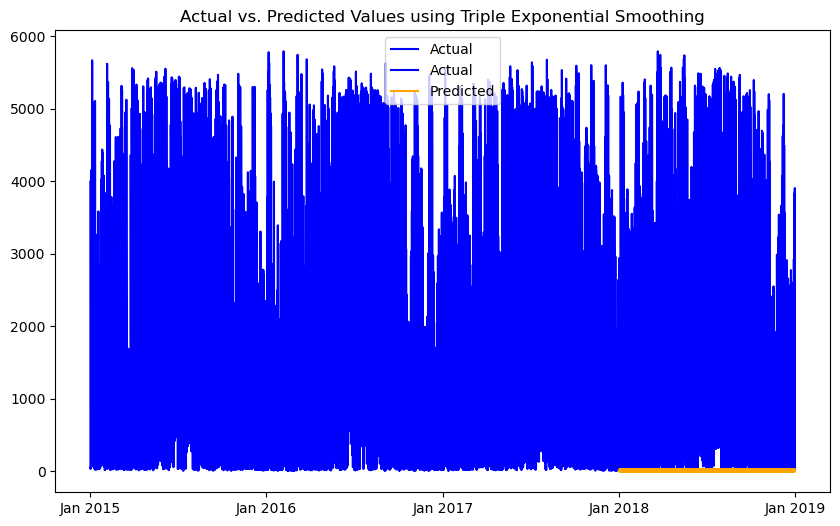

Mean Squared Error (MSE) for Exponential Smoothing model: 4603458.875312855
Root Mean Squared Error (RMSE) for Exponential Smoothing model: 2145.5672618943586
Mean Absolute Error (MAE) for Exponential Smoothing model: 1362.5172554730261
R-squared for Exponential Smoothing model: -0.6745670113482827
Adjusted R-squared for Exponential Smoothing model: -0.674758237454409
Mean Absolute Percentage Error (MAPE) for Exponential Smoothing model: 90.20353099458413


In [132]:
# Create a new DataFrame to hold the predicted values with the corresponding date
predicted_data = pd.DataFrame({'date_time': test_data.index, 'solar_output': predictions})

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['solar_output'], label='Actual', color='blue')
plt.plot(test_data.index, test_data['solar_output'], label='Actual', color='blue')
plt.plot(predicted_data['date_time'], predicted_data['solar_output'], label='Predicted', color='orange')

# Set the major locator and formatter for the x-axis
years_locator = YearLocator()
years_formatter = DateFormatter('%b %Y')
plt.gca().xaxis.set_major_locator(years_locator)
plt.gca().xaxis.set_major_formatter(years_formatter)

plt.legend()
plt.title('Actual vs. Predicted Values using Triple Exponential Smoothing')
plt.show()

# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate evaluation metrics for Exponential Smoothing model
mse_exp_smooth = np.mean((test_data['solar_output'] - predictions) ** 2)
rmse_exp_smooth = np.sqrt(mse_exp_smooth)
mae_exp_smooth = np.mean(np.abs(test_data['solar_output'] - predictions))
r2_exp_smooth = 1 - (np.sum((test_data['solar_output'] - predictions) ** 2) / np.sum((test_data['solar_output'] - test_data['solar_output'].mean()) ** 2))
adjusted_r2_exp_smooth = 1 - (1 - r2_exp_smooth) * (len(test_data) - 1) / (len(test_data) - 2)

# Calculate the Mean Absolute Percentage Error (MAPE)
mape_exp_smooth = mean_absolute_percentage_error(test_data['solar_output'], predictions)

# Print evaluation metrics for Exponential Smoothing model
print("Mean Squared Error (MSE) for Exponential Smoothing model:", mse_exp_smooth)
print("Root Mean Squared Error (RMSE) for Exponential Smoothing model:", rmse_exp_smooth)
print("Mean Absolute Error (MAE) for Exponential Smoothing model:", mae_exp_smooth)
print("R-squared for Exponential Smoothing model:", r2_exp_smooth)
print("Adjusted R-squared for Exponential Smoothing model:", adjusted_r2_exp_smooth)
print("Mean Absolute Percentage Error (MAPE) for Exponential Smoothing model:", mape_exp_smooth)

# SimpleRNN Deep Learning Model

In [35]:
df = df.drop(['year'], axis=1)
df

,city_name,temp,temp_min,temp_max,humidity,wind_speed,wind_deg,weather_main,weather_description,solar_output
date_time,,,,,,,,,,
2014-12-31 23:00:00+00:00,0.0,272.491463,272.491463,272.491463,82.4,2.0,135.2,0.0,0.0,49.0
2015-01-01 00:00:00+00:00,0.0,272.512700,272.512700,272.512700,82.4,2.0,135.8,0.0,0.0,50.0
2015-01-01 01:00:00+00:00,0.0,272.099137,272.099137,272.099137,82.0,2.4,119.0,0.0,0.0,50.0
2015-01-01 02:00:00+00:00,0.0,272.089469,272.089469,272.089469,82.0,2.4,119.2,0.0,0.0,50.0
2015-01-01 03:00:00+00:00,0.0,272.145900,272.145900,272.145900,82.0,2.4,118.4,0.0,0.0,42.0
...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,0.0,284.470000,283.350000,285.550000,73.6,1.4,151.4,0.0,0.0,85.0
2018-12-31 19:00:00+00:00,0.0,282.294000,280.950000,283.350000,68.0,1.8,160.4,0.0,0.0,33.0
2018-12-31 20:00:00+00:00,0.0,280.850000,280.350000,281.350000,71.4,2.6,226.0,0.0,0.0,31.0


In [36]:
df_for_training = df.loc['2015-01-01':'2017-12-31']
test_data = df.loc['2018-01-01':'2018-12-31']
df_for_training

,city_name,temp,temp_min,temp_max,humidity,wind_speed,wind_deg,weather_main,weather_description,solar_output
date_time,,,,,,,,,,
2015-01-01 00:00:00+00:00,0.0,272.512700,272.512700,272.512700,82.4,2.0,135.8,0.0,0.0,50.0
2015-01-01 01:00:00+00:00,0.0,272.099137,272.099137,272.099137,82.0,2.4,119.0,0.0,0.0,50.0
2015-01-01 02:00:00+00:00,0.0,272.089469,272.089469,272.089469,82.0,2.4,119.2,0.0,0.0,50.0
2015-01-01 03:00:00+00:00,0.0,272.145900,272.145900,272.145900,82.0,2.4,118.4,0.0,0.0,42.0
2015-01-01 04:00:00+00:00,0.0,272.024000,272.024000,272.024000,82.6,2.4,174.8,0.0,0.0,34.0
...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00+00:00,0.0,286.178000,284.750000,287.550000,65.6,5.4,246.0,1.0,1.0,9.0
2017-12-31 20:00:00+00:00,0.0,285.946000,284.750000,287.150000,66.6,4.2,266.0,1.0,1.0,9.0
2017-12-31 21:00:00+00:00,0.0,285.622000,284.550000,286.750000,68.2,4.0,226.0,1.0,1.0,9.0


In [37]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
df_for_training_scaled.shape

(26304, 10)

In [38]:
scaler_test = MinMaxScaler(feature_range=(0, 1))
scaler_test = scaler_test.fit(test_data)
test_data_scaled = scaler.transform(test_data)
test_data_scaled.shape

(8759, 10)

In [39]:
# Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.

# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(len(df_for_training_scaled) - n_future):
    trainX.append(df_for_training_scaled[i:i+1, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future:i + n_future + 1, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (26303, 1, 10).
trainY shape == (26303, 1).


In [40]:
# Empty lists to be populated using formatted test data
testX = []
testY = []

n_future = 1  # Number of days we want to look into the future based on the past days.

# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(len(test_data_scaled) - n_future + 1):
    testX.append(test_data_scaled[i:i + n_future, 0:test_data.shape[1]])
    testY.append(test_data_scaled[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

testX shape == (8759, 1, 10).
testY shape == (8759, 1).


In [41]:
df_for_training = df.loc['2015-01-01':'2017-12-31']
test_data = df.loc['2018-01-01':'2018-12-31']
df_for_training

,city_name,temp,temp_min,temp_max,humidity,wind_speed,wind_deg,weather_main,weather_description,solar_output
date_time,,,,,,,,,,
2015-01-01 00:00:00+00:00,0.0,272.512700,272.512700,272.512700,82.4,2.0,135.8,0.0,0.0,50.0
2015-01-01 01:00:00+00:00,0.0,272.099137,272.099137,272.099137,82.0,2.4,119.0,0.0,0.0,50.0
2015-01-01 02:00:00+00:00,0.0,272.089469,272.089469,272.089469,82.0,2.4,119.2,0.0,0.0,50.0
2015-01-01 03:00:00+00:00,0.0,272.145900,272.145900,272.145900,82.0,2.4,118.4,0.0,0.0,42.0
2015-01-01 04:00:00+00:00,0.0,272.024000,272.024000,272.024000,82.6,2.4,174.8,0.0,0.0,34.0
...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00+00:00,0.0,286.178000,284.750000,287.550000,65.6,5.4,246.0,1.0,1.0,9.0
2017-12-31 20:00:00+00:00,0.0,285.946000,284.750000,287.150000,66.6,4.2,266.0,1.0,1.0,9.0
2017-12-31 21:00:00+00:00,0.0,285.622000,284.550000,286.750000,68.2,4.0,226.0,1.0,1.0,9.0


In [42]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
df_for_training_scaled.shape

(26304, 10)

In [43]:
scaler_test = MinMaxScaler(feature_range=(0, 1))
scaler_test = scaler_test.fit(test_data)
test_data_scaled = scaler.transform(test_data)
test_data_scaled.shape

(8759, 10)

In [44]:
# Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.

# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(len(df_for_training_scaled) - n_future):
    trainX.append(df_for_training_scaled[i:i+1, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future:i + n_future + 1, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (26303, 1, 10).
trainY shape == (26303, 1).


In [45]:
# Empty lists to be populated using formatted test data
testX = []
testY = []

n_future = 1  # Number of days we want to look into the future based on the past days.

# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(len(test_data_scaled) - n_future + 1):
    testX.append(test_data_scaled[i:i + n_future, 0:test_data.shape[1]])
    testY.append(test_data_scaled[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

testX shape == (8759, 1, 10).
testY shape == (8759, 1).


In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Define the function to build the Autoencoder model
def build_model(hp):
    model = Sequential()
    model.add(SimpleRNN(hp.Int('units_simplernn1', min_value=32, max_value=128, step=32),
                        activation='relu',
                        input_shape=(trainX.shape[1], trainX.shape[2]),
                        return_sequences=True))
    model.add(SimpleRNN(hp.Int('units_simplernn2', min_value=16, max_value=64, step=16),
                        activation='relu',
                        return_sequences=False))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(trainY.shape[1]))

    model.compile(optimizer='adam', loss='mse')

    return model

# Initialize the Keras Tuner RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of hyperparameter combinations to try
    directory='tuner_results',  # Directory to store the results
    project_name='my_simplernn_tuning'  # Project name
)

# Search for the best hyperparameter configuration
tuner.search(trainX, trainY, epochs=50, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Summary of the best model
best_model.summary()

Trial 10 Complete [00h 00m 17s]
val_loss: 0.0364348366856575

Best val_loss So Far: 0.03628452867269516
Total elapsed time: 00h 04m 25s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 96)             10272     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 16)                1808      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 12,097
Trainable params: 12,097
Non-trainable params: 0
_________________________________________________________________


In [226]:
#Separate dates for future plotting
train_dates = df_for_training.index

Epoch 1/20
658/658 [==============================] - 2s 4ms/step - loss: 0.0226 - val_loss: 0.0378
Epoch 2/20
658/658 [==============================] - 2s 3ms/step - loss: 0.0228 - val_loss: 0.0386
Epoch 3/20
658/658 [==============================] - 2s 3ms/step - loss: 0.0227 - val_loss: 0.0393
Epoch 4/20
658/658 [==============================] - 2s 4ms/step - loss: 0.0224 - val_loss: 0.0381
Epoch 5/20
658/658 [==============================] - 2s 4ms/step - loss: 0.0225 - val_loss: 0.0386
Epoch 6/20
658/658 [==============================] - 2s 4ms/step - loss: 0.0226 - val_loss: 0.0382


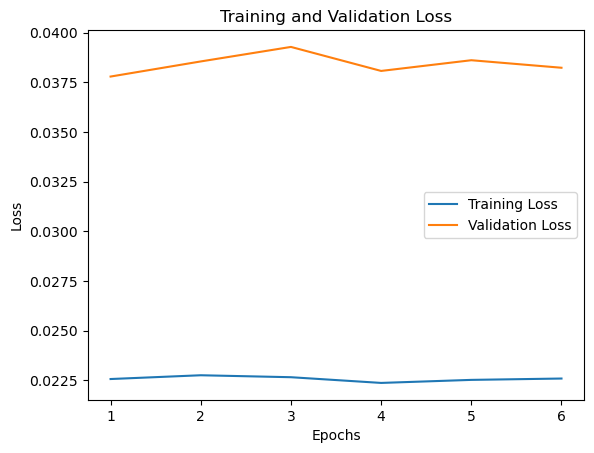

In [50]:
# Plot the losses# Fit the model with early stopping
history = best_model.fit(trainX, trainY, epochs=20, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

# Extract the loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [51]:
#Make prediction
prediction = best_model.predict(testX)
prediction

274/274 [==============================] - 1s 2ms/step


array([[0.00679458],
       [0.01783388],
       [0.02103899],
       ...,
       [0.0074952 ],
       [0.00900463],
       [0.01392936]], dtype=float32)

In [52]:
prediction_copies = np.repeat(prediction, test_data.shape[1], axis=-1)
y_pred = scaler_test.inverse_transform(prediction_copies)[:,-1]
y_pred

array([ 41.340603, 105.258156, 123.81576 , ...,  45.397186,  54.13683 ,
        82.651   ], dtype=float32)

In [53]:
y_true = scaler.inverse_transform(df_for_training_scaled)[:,-1]

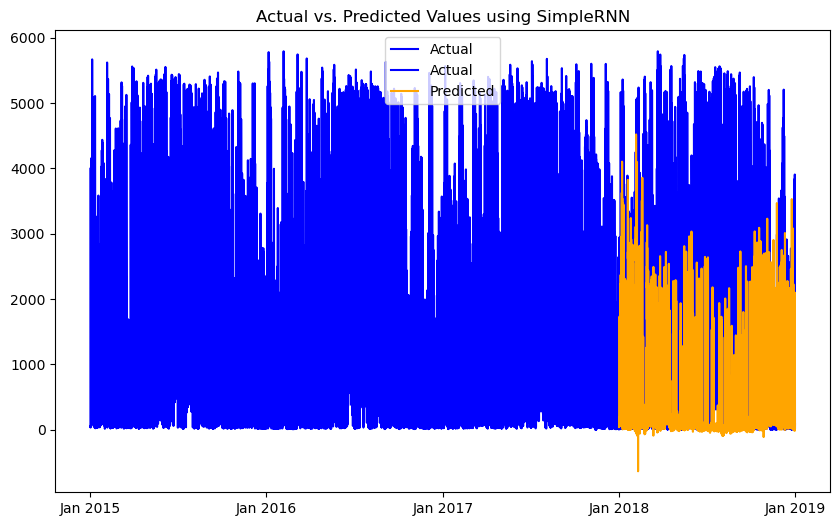

Mean Squared Error (MSE): 4395730.679962534
Root Mean Squared Error (RMSE): 2096.599790127466
Mean Absolute Error (MAE): 1365.2806889350693
R-squared: -0.5990032249254229
Adjusted R-squared: -0.5991858220734103
Mean Absolute Percentage Error (MAPE): 558.9744688750728


In [55]:
# Create a new DataFrame to hold the predicted values with the corresponding date
predicted_data = pd.DataFrame({'date_time': test_data.index, 'solar_output': y_pred})

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['solar_output'], label='Actual', color='blue')
plt.plot(test_data.index, test_data['solar_output'], label='Actual', color='blue')
plt.plot(predicted_data['date_time'], predicted_data['solar_output'], label='Predicted', color='orange')

# Set the major locator and formatter for the x-axis
years_locator = YearLocator()
years_formatter = DateFormatter('%b %Y')
plt.gca().xaxis.set_major_locator(years_locator)
plt.gca().xaxis.set_major_formatter(years_formatter)

plt.legend()
plt.title('Actual vs. Predicted Values using SimpleRNN')
plt.show()

# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate evaluation metrics for Exponential Smoothing model
mse = np.mean((test_data['solar_output'] - y_pred) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(test_data['solar_output'] - y_pred))
r2 = 1 - (np.sum((test_data['solar_output'] - y_pred) ** 2) / np.sum((test_data['solar_output'] - test_data['solar_output'].mean()) ** 2))
adjusted_r2 = 1 - (1 - r2) * (len(test_data) - 1) / (len(test_data) - 2)

# Calculate the Mean Absolute Percentage Error (MAPE)|
mape = mean_absolute_percentage_error(test_data['solar_output'], y_pred)

# Print evaluation metrics for Exponential Smoothing model
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)
print("Adjusted R-squared:", adjusted_r2)
print("Mean Absolute Percentage Error (MAPE):", mape)

## GRU

In [34]:
df_for_training = df.loc['2015-01-01':'2017-12-31']
test_data = df.loc['2018-01-01':'2018-12-31']
df_for_training

,city_name,temp,temp_min,temp_max,humidity,wind_speed,wind_deg,weather_main,weather_description,solar_output
date_time,,,,,,,,,,
2015-01-01 00:00:00+00:00,0.0,272.512700,272.512700,272.512700,82.4,2.0,135.8,0.0,0.0,50.0
2015-01-01 01:00:00+00:00,0.0,272.099137,272.099137,272.099137,82.0,2.4,119.0,0.0,0.0,50.0
2015-01-01 02:00:00+00:00,0.0,272.089469,272.089469,272.089469,82.0,2.4,119.2,0.0,0.0,50.0
2015-01-01 03:00:00+00:00,0.0,272.145900,272.145900,272.145900,82.0,2.4,118.4,0.0,0.0,42.0
2015-01-01 04:00:00+00:00,0.0,272.024000,272.024000,272.024000,82.6,2.4,174.8,0.0,0.0,34.0
...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00+00:00,0.0,286.178000,284.750000,287.550000,65.6,5.4,246.0,1.0,1.0,9.0
2017-12-31 20:00:00+00:00,0.0,285.946000,284.750000,287.150000,66.6,4.2,266.0,1.0,1.0,9.0
2017-12-31 21:00:00+00:00,0.0,285.622000,284.550000,286.750000,68.2,4.0,226.0,1.0,1.0,9.0


In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
df_for_training_scaled.shape

(26304, 10)

In [36]:
scaler_test = MinMaxScaler(feature_range=(0, 1))
scaler_test = scaler_test.fit(test_data)
test_data_scaled = scaler.transform(test_data)
test_data_scaled.shape

(8759, 10)

In [37]:
# Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.

# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(len(df_for_training_scaled) - n_future):
    trainX.append(df_for_training_scaled[i:i+1, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future:i + n_future + 1, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (26303, 1, 10).
trainY shape == (26303, 1).


In [38]:
# Empty lists to be populated using formatted test data
testX = []
testY = []

n_future = 1  # Number of days we want to look into the future based on the past days.

# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(len(test_data_scaled) - n_future + 1):
    testX.append(test_data_scaled[i:i + n_future, 0:test_data.shape[1]])
    testY.append(test_data_scaled[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

testX shape == (8759, 1, 10).
testY shape == (8759, 1).


In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Define the function to build the Autoencoder model
def build_model(hp):
    model = Sequential()
    model.add(GRU(hp.Int('units_gru1', min_value=32, max_value=128, step=32),
                  activation='relu',
                  input_shape=(trainX.shape[1], trainX.shape[2]),
                  return_sequences=True))
    model.add(GRU(hp.Int('units_gru2', min_value=16, max_value=64, step=16),
                  activation='relu',
                  return_sequences=False))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(trainY.shape[1]))

    model.compile(optimizer='adam', loss='mse')

    return model

# Initialize the Keras Tuner RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of hyperparameter combinations to try
    directory='tuner_results',  # Directory to store the results
    project_name='my_gru_tuning'  # Project name
)

# Search for the best hyperparameter configuration
tuner.search(trainX, trainY, epochs=50, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Summary of the best model
best_model.summary()

Trial 10 Complete [00h 00m 25s]
val_loss: 0.03655753657221794

Best val_loss So Far: 0.03632865101099014
Total elapsed time: 00h 04m 57s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 64)             14592     
                                                                 
 gru_1 (GRU)                 (None, 16)                3936      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 18,545
Trainable params: 18,545
Non-trainable params: 0
_________________________________________________________________


In [181]:
#Separate dates for future plotting
train_dates = df_for_training.index

Epoch 1/20
658/658 [==============================] - 6s 5ms/step - loss: 0.0245 - val_loss: 0.0374
Epoch 2/20
658/658 [==============================] - 3s 4ms/step - loss: 0.0241 - val_loss: 0.0371
Epoch 3/20
658/658 [==============================] - 3s 4ms/step - loss: 0.0237 - val_loss: 0.0374
Epoch 4/20
658/658 [==============================] - 3s 4ms/step - loss: 0.0241 - val_loss: 0.0363
Epoch 5/20
658/658 [==============================] - 3s 4ms/step - loss: 0.0237 - val_loss: 0.0374
Epoch 6/20
658/658 [==============================] - 3s 4ms/step - loss: 0.0239 - val_loss: 0.0367


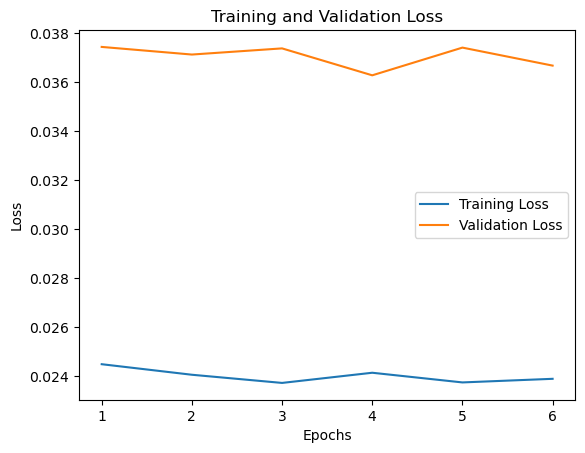

In [40]:
# Fit the model with early stopping for short-term time series data
history = best_model.fit(trainX, trainY, epochs=20, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

# Function to plot training and validation losses
def plot_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Plot the losses
plot_losses(history)

In [41]:
#Make prediction
prediction = best_model.predict(testX)
prediction

274/274 [==============================] - 1s 2ms/step


array([[0.01962537],
       [0.0269169 ],
       [0.03055221],
       ...,
       [0.02264746],
       [0.02312564],
       [0.02900304]], dtype=float32)

In [42]:
prediction_copies = np.repeat(prediction, test_data.shape[1], axis=-1)
y_pred = scaler_test.inverse_transform(prediction_copies)[:,-1]
y_pred

array([115.63088, 157.84888, 178.89731, ..., 133.12877, 135.89746,
       169.92763], dtype=float32)

In [43]:
y_true = scaler.inverse_transform(df_for_training_scaled)[:,-1]
y_true

array([50., 50., 50., ...,  9.,  9.,  9.])

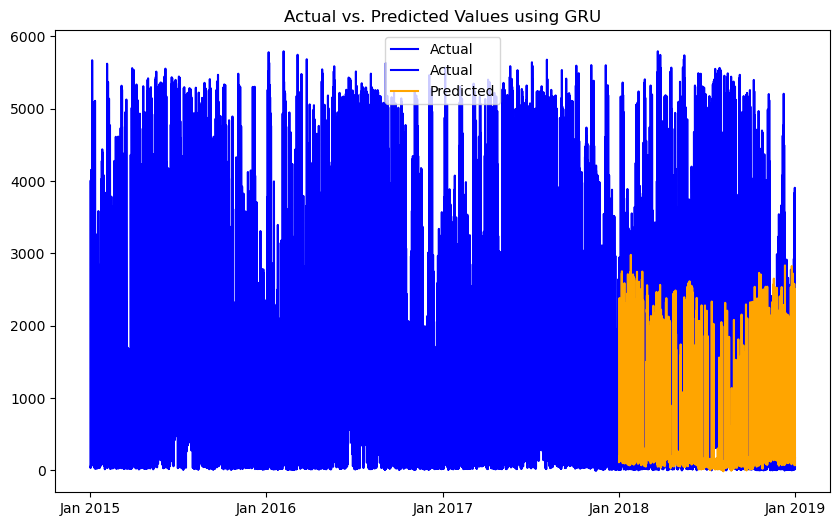

Mean Squared Error (MSE): 4348006.394612543
Root Mean Squared Error (RMSE): 2085.187376379529
Mean Absolute Error (MAE): 1366.7688540404297
R-squared: -0.5816429060756461
Adjusted R-squared: -0.5818235207731539
Mean Absolute Percentage Error (MAPE): 782.8499611101989


In [44]:
# Create a new DataFrame to hold the predicted values with the corresponding date
predicted_data = pd.DataFrame({'date_time': test_data.index, 'solar_output': y_pred})

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['solar_output'], label='Actual', color='blue')
plt.plot(test_data.index, test_data['solar_output'], label='Actual', color='blue')
plt.plot(predicted_data['date_time'], predicted_data['solar_output'], label='Predicted', color='orange')

# Set the major locator and formatter for the x-axis
years_locator = YearLocator()
years_formatter = DateFormatter('%b %Y')
plt.gca().xaxis.set_major_locator(years_locator)
plt.gca().xaxis.set_major_formatter(years_formatter)

plt.legend()
plt.title('Actual vs. Predicted Values using GRU')
plt.show()

# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate evaluation metrics
mse = np.mean((test_data['solar_output'] - y_pred) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(test_data['solar_output'] - y_pred))
r2 = 1 - (np.sum((test_data['solar_output'] - y_pred) ** 2) / np.sum((test_data['solar_output'] - test_data['solar_output'].mean()) ** 2))
adjusted_r2 = 1 - (1 - r2) * (len(test_data) - 1) / (len(test_data) - 2)

# Calculate the Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(test_data['solar_output'], y_pred)

# Print evaluation metrics for Exponential Smoothing model
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)
print("Adjusted R-squared:", adjusted_r2)
print("Mean Absolute Percentage Error (MAPE):", mape)